In [4]:

# Mount Google Drive in Google Colab for data storage and access
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Install required libraries
!pip install yfinance ta keras-tuner pyswarm
!pip install --upgrade xgboost
!pip install scikeras
!pip install scikit-optimize
!pip install optuna
!pip install scikit-learn





  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=e2c5536e0580531041eb73c035d0bce7e740ca0c616f0c234dfb4aaa8f8b0c17
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=da64e6c53ecd85d045091969368045a0f2b19b60aba77d62e51081050c5d9a73
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built ta pyswarm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12=

In [60]:
# Standard Python Libraries
import os
import pickle
import random
import datetime  # Import the datetime module
import optuna
import json

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import joblib
from statsmodels.tsa.stattools import adfuller, kpss

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import matplotlib.dates as mdates
from IPython.display import Image, display

# Financial Data Retrieval
import yfinance as yf

# Machine Learning and Preprocessing
import sklearn
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, learning_curve, cross_val_score, KFold
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR

# Technical Analysis
import ta
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator, EMAIndicator

# Deep Learning with TensorFlow and Keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    LSTM, Dense, Input, Bidirectional, Dropout, BatchNormalization,
    LayerNormalization, Concatenate, Activation, Flatten, Attention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    TensorBoard , EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model, model_to_dot
from IPython.display import SVG
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
# Hyperparameter Tuning with Bayesian Optimization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras_tuner import BayesianOptimization
from keras.backend import clear_session

# Optimization Utilities
from skopt.space import Integer, Real
from skopt import gp_minimize
from skopt.utils import use_named_args

# Additional Libraries for Optimization and Ensemble Learning
from pyswarm import pso
import xgboost as xgb


In [13]:
# Function to set random seeds for reproducibility
def set_random_seeds(seed_value=42):
    """
    Configure random seed for reproducibility.
    Args:
    - seed_value: Seed for RNGs (default: 42).
    Returns:
    - None
    """
    # Set seed for numpy RNG
    np.random.seed(seed_value)

    # Set seed for Python's random RNG
    random.seed(seed_value)

    # Set seed for TensorFlow RNG
    tf.random.set_seed(seed_value)

    # Configure XGBoost verbosity to 0 (silent)
    xgb.set_config(verbosity=0)

    # Set seed for XGBoost parameters
    xgparam = {'seed': seed_value}

# Initialise random seed for consistency
set_random_seeds()


In [12]:
# Function to fetch and save stock data
def fetch_data(ticker, start, end, output_dir):
    """
    Fetch and save stock data for a ticker.
    Args:
    - ticker (str): Stock ticker symbol.
    - start (str): Start date (YYYY-MM-DD).
    - end (str): End date (YYYY-MM-DD).
    - output_dir (str): Directory to save data.
    Returns:
    - pd.DataFrame: Loaded data for ticker.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Define file path for the data
    file_path = os.path.join(output_dir,
                             f"{ticker}.csv")

    # Download data if not already saved
    if not os.path.exists(file_path):
        data = yf.download(ticker, start=start, end=end)
        data.to_csv(file_path)

    # Load and return the data as DataFrame
    return pd.read_csv(file_path)

# Function to process stock data
def process_data(df, ticker):
    """
    Process data: keep 'Adj Close', rename.
    Args:
    - df (pd.DataFrame): Stock data.
    - ticker (str): Stock ticker symbol.
    Returns:
    - pd.DataFrame: Processed data with 'Adj Close'.
    """
    # Convert 'Date' to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Keep only 'Date' and 'Adj Close' columns
    df = df[['Date', 'Adj Close']]

    # Rename 'Adj Close' to ticker symbol
    df = df.rename(columns={'Adj Close': ticker})

    # Return the processed DataFrame
    return df

# Function to download and process data
def download_and_process_data(tickers, start, end, out_dir):
    """
    Download and process stock data.
    Args:
    - tickers (list): List of stock tickers.
    - start (str): Start date (YYYY-MM-DD).
    - end (str): End date (YYYY-MM-DD).
    - out_dir (str): Directory to save data.
    Returns:
    - pd.DataFrame: Combined data for tickers.
    """
    # Initialize empty DataFrame
    combined_df = None

    # Loop through each ticker
    for ticker in tickers:
        # Fetch raw data
        raw_df = fetch_data(ticker, start, end, out_dir)

        # Process data for current ticker
        processed_df = process_data(raw_df,
                                    ticker.split('.')[0])

        # Merge processed data with combined_df
        combined_df = (processed_df if combined_df is None
                       else pd.merge(combined_df, processed_df,
                                     on='Date', how='inner'))

    # Return the combined DataFrame
    return combined_df

# Main function to manage data download and processing
def main():
    """
    Main function to download and process data.
    Call to execute data download and processing.
    """
    # Define tickers for each dataset
    tickers_train = ['SVT.L', 'CCH.L', 'BATS.L',
                     'GLEN.L', 'LGEN.L']
    tickers_test = ['RR.L', 'RTO.L', 'SGE.L',
                    'LAND.L', 'SN.L']
    tickers_extra = ['ULVR.L', 'DGE.L', 'BARC.L',
                     'HSBA.L', 'TSCO.L', 'VOD.L',
                     'BP.L', 'SHEL.L', 'AZN.L',
                     'GSK.L']

    # Define date ranges for datasets
    date_train = ('2014-01-01', '2023-12-31')
    date_test = ('2024-01-01', '2024-03-31')
    date_extra = ('2024-01-01', '2024-06-30')

    # Directories for saving data
    dirs = ('train_data', 'test_data', 'extra_data')

    # Download and process training data
    combined_train_data = download_and_process_data(
        tickers_train, *date_train, dirs[0])

    # Download and process test data
    combined_test_data = download_and_process_data(
        tickers_test, *date_test, dirs[1])

    # Download and process extra data
    combined_extra_data = download_and_process_data(
        tickers_extra, *date_extra, dirs[2])

    # Print first few rows of each dataset
    print(combined_train_data.head())
    print(combined_test_data.head())
    print(combined_extra_data.head())

# Execute main function when script is run
if __name__ == "__main__":
    main()


        Date     SVT     CCH    BATS   GLEN   LGEN
0 2014-01-02 1098.84 1241.76 1680.69 208.17 111.72
1 2014-01-03 1109.22 1215.69 1676.76 206.16 111.67
2 2014-01-06 1105.33 1236.13 1679.64 205.36 113.32
3 2014-01-07 1081.32 1268.54 1669.16 207.07 114.83
4 2014-01-08 1061.86 1254.45 1652.92 211.06 113.93
        Date     RR    RTO     SGE   LAND      SN
0 2024-01-02 298.10 424.12 1145.12 685.24 1043.87
1 2024-01-03 294.80 403.13 1131.36 674.22 1026.27
2 2024-01-04 297.80 405.97 1127.92 673.45 1027.73
3 2024-01-05 296.60 404.01 1118.10 672.09 1018.93
4 2024-01-08 305.20 406.66 1130.38 675.96 1046.80
        Date    ULVR     DGE   BARC   HSBA   TSCO   VOD     BP    SHEL  \
0 2024-01-02 3729.05 2789.42 148.44 572.18 285.32 65.66 451.63 2486.36   
1 2024-01-03 3756.84 2757.27 146.37 567.55 289.89 65.43 452.55 2503.26   
2 2024-01-04 3746.60 2778.54 148.73 574.00 294.37 66.31 453.98 2504.71   
3 2024-01-05 3733.44 2735.50 148.74 575.63 292.91 66.27 454.37 2482.02   
4 2024-01-08 3736.36 274





Performing EDA on training data...

Basic Stats (Train):
                                Date     SVT     CCH    BATS    GLEN    LGEN
count                           2518 2518.00 2518.00 2518.00 2518.00 2518.00
mean   2018-12-26 01:28:04.193804544 1849.83 1703.70 2327.19  259.31  170.37
min              2014-01-02 00:00:00 1061.86  765.29 1509.61   52.58   94.39
25%              2016-06-29 06:00:00 1497.57 1200.27 2011.39  200.40  140.63
50%              2018-12-20 12:00:00 1688.84 1830.01 2199.26  239.29  165.62
75%              2021-06-22 18:00:00 2195.04 2098.71 2688.54  301.30  207.32
max              2023-12-29 00:00:00 2883.07 2504.72 3410.24  540.28  249.00
std                              NaN  457.24  482.72  414.15  109.06   37.11

Missing Values (Train):
Date    0
SVT     0
CCH     0
BATS    0
GLEN    0
LGEN    0
dtype: int64

Correlation Matrix (Train):
      SVT  CCH  BATS  GLEN  LGEN
SVT  1.00 0.56  0.30  0.67  0.84
CCH  0.56 1.00  0.13  0.47  0.78
BATS 0.30 0.13  1.00

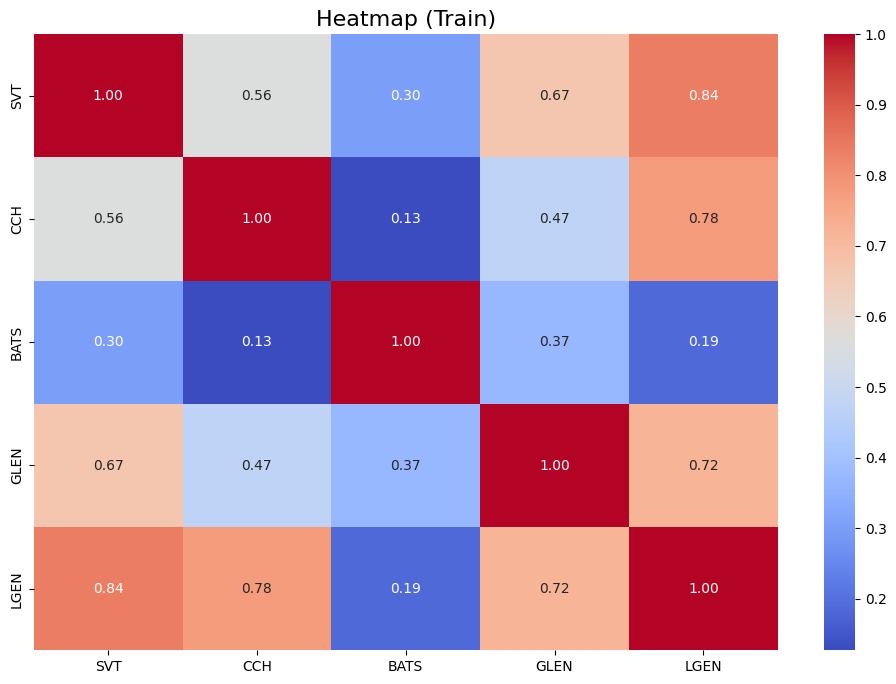


Log Returns (Train):


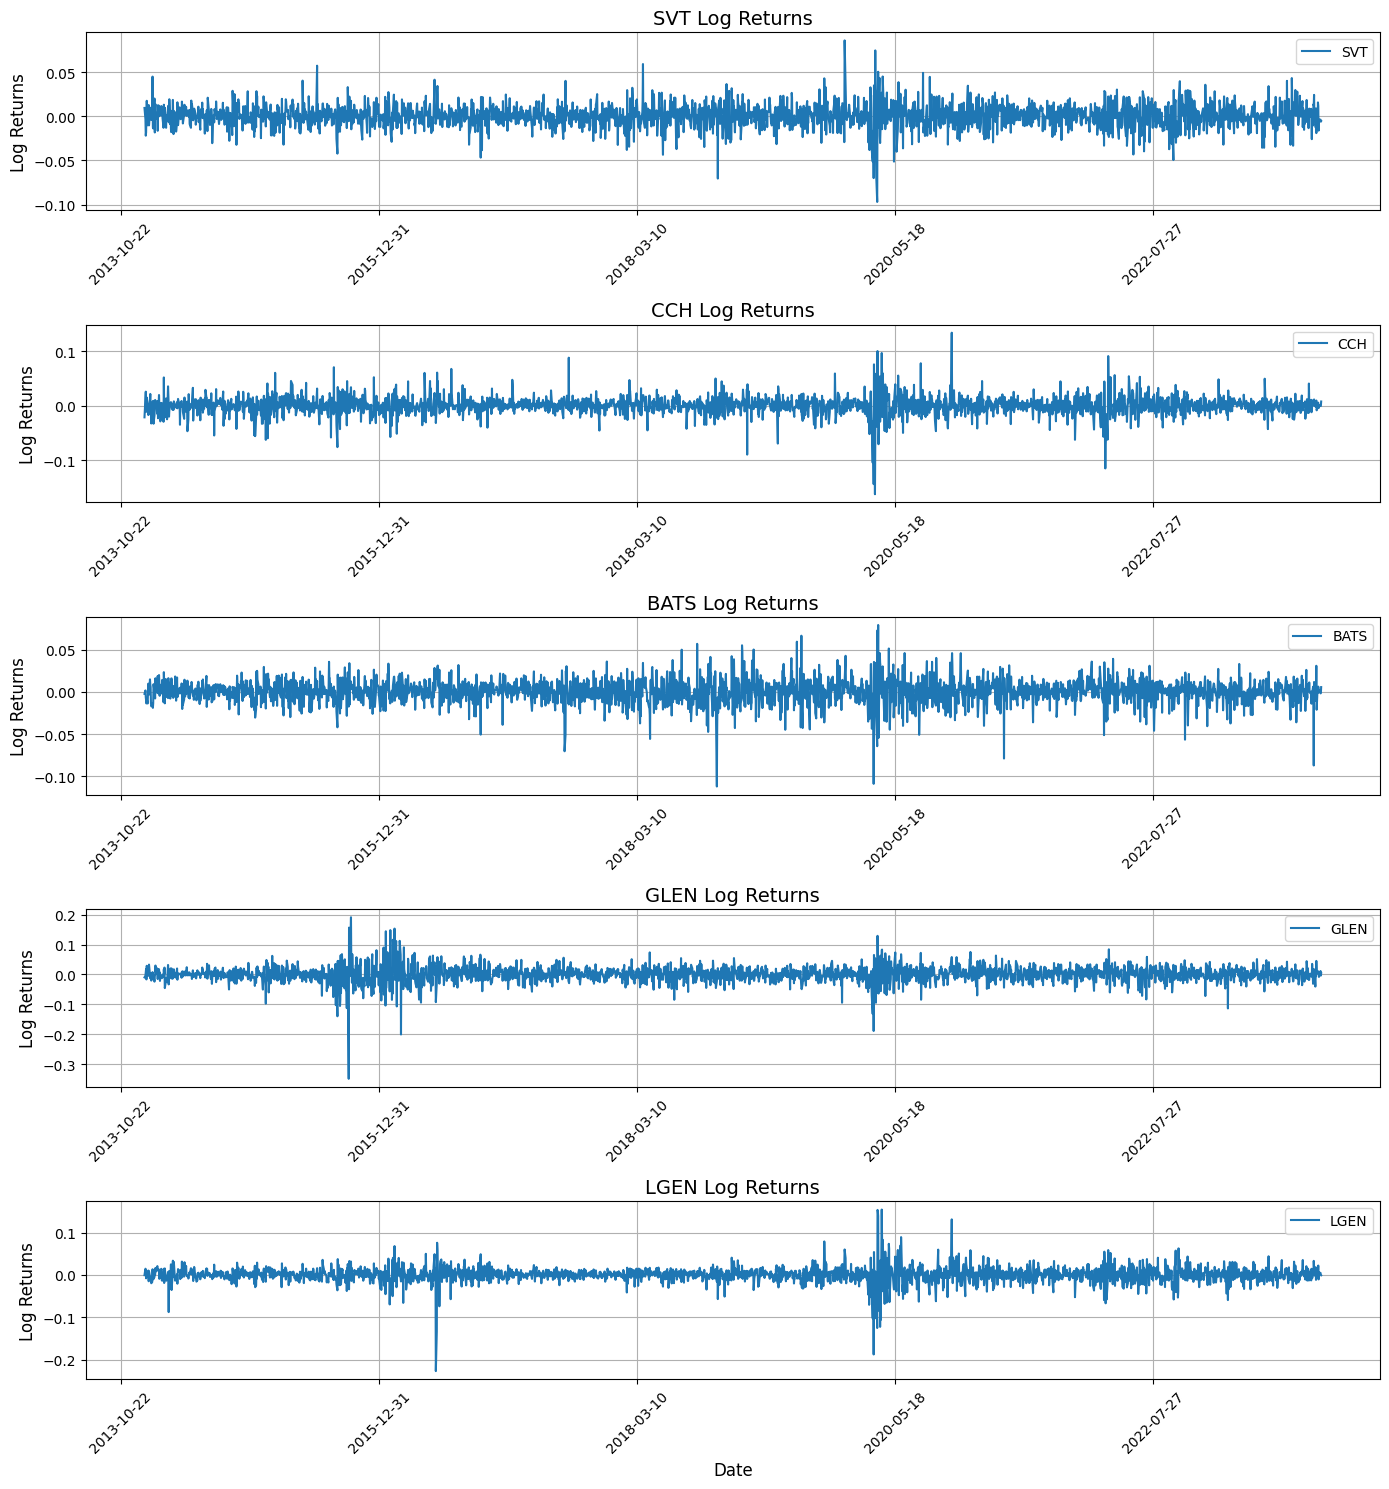


Performing EDA on test data...

Basic Stats (Test):
                      Date     RR    RTO     SGE   LAND      SN
count                   63  63.00  63.00   63.00  63.00   63.00
mean   2024-02-14 00:00:00 342.21 421.78 1185.85 631.02 1058.12
min    2024-01-02 00:00:00 294.80 384.89 1118.10 601.65  991.60
25%    2024-01-23 12:00:00 305.85 397.98 1149.41 613.45 1031.89
50%    2024-02-14 00:00:00 320.00 412.84 1170.28 624.13 1063.43
75%    2024-03-06 12:00:00 381.10 442.65 1221.19 644.33 1078.83
max    2024-03-28 00:00:00 428.00 494.43 1273.59 685.24 1112.32
std                    NaN  43.52  30.47   41.94  21.31   30.44

Missing Values (Test):
Date    0
RR      0
RTO     0
SGE     0
LAND    0
SN      0
dtype: int64

Correlation Matrix (Test):
        RR   RTO   SGE  LAND    SN
RR    1.00  0.87  0.94 -0.42 -0.49
RTO   0.87  1.00  0.79 -0.25 -0.42
SGE   0.94  0.79  1.00 -0.48 -0.44
LAND -0.42 -0.25 -0.48  1.00 -0.22
SN   -0.49 -0.42 -0.44 -0.22  1.00

Correlation Heatmap (Test):


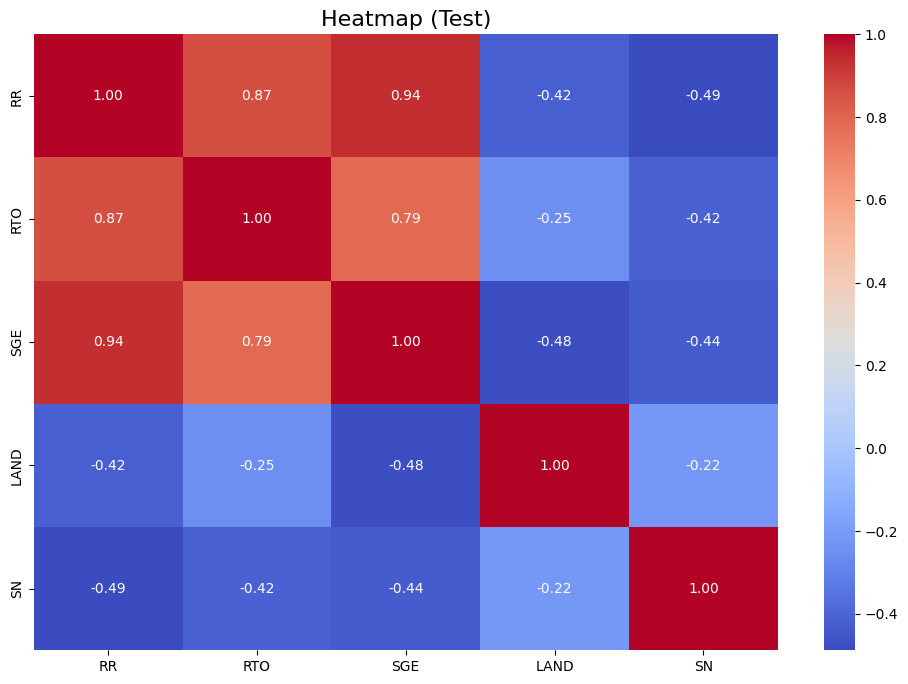


Log Returns (Test):


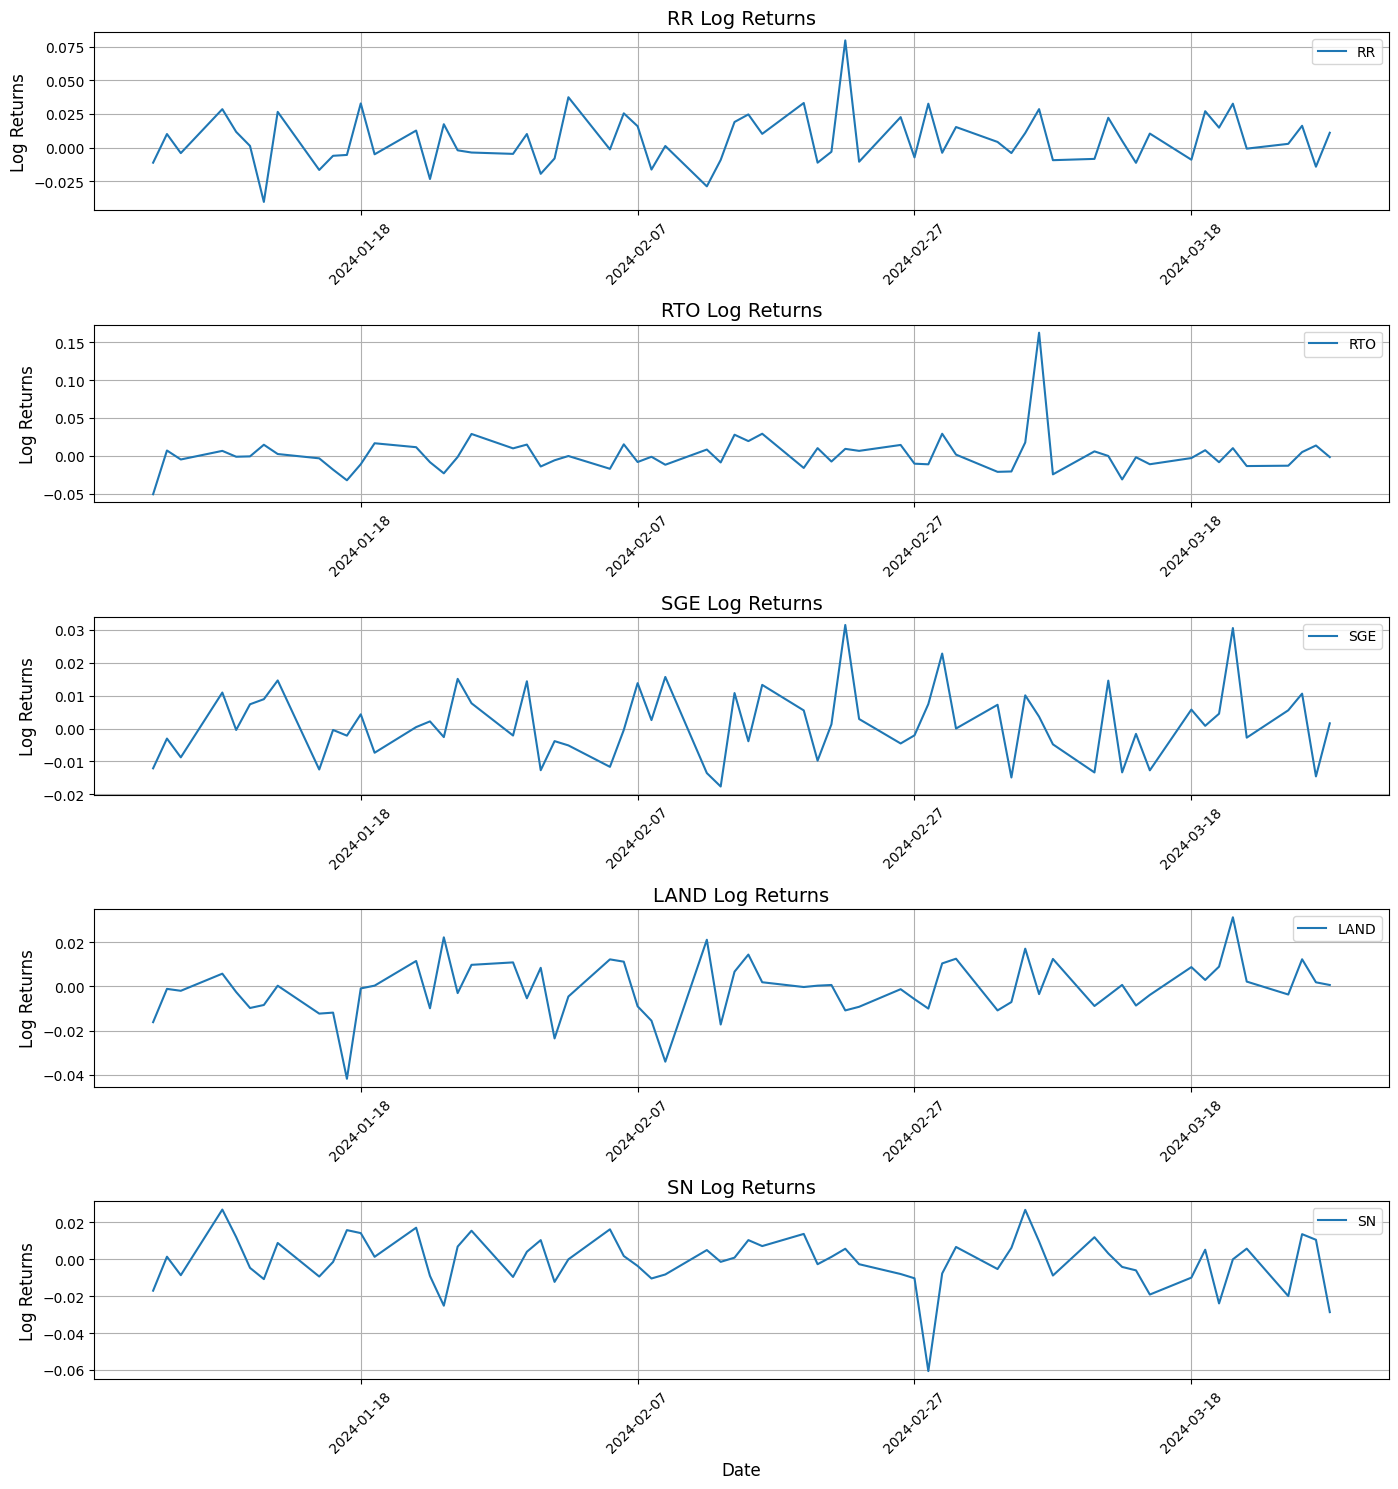


Performing EDA on extra data...

Basic Stats (Extra):
                                Date    ULVR     DGE   BARC   HSBA   TSCO  \
count                            123  123.00  123.00 123.00 123.00 123.00   
mean   2024-03-30 15:24:52.682926848 3964.39 2788.03 177.27 610.78 289.14   
min              2024-01-02 00:00:00 3615.94 2489.50 134.29 533.34 266.43   
25%              2024-02-14 12:00:00 3759.36 2716.09 148.22 560.56 278.16   
50%              2024-03-28 00:00:00 3881.64 2808.00 179.14 597.36 286.39   
75%              2024-05-14 12:00:00 4221.72 2882.00 203.38 674.17 302.48   
max              2024-06-28 00:00:00 4416.05 2994.70 217.12 695.53 315.00   
std                              NaN  245.41  121.24  27.75  54.44  13.94   

         VOD     BP    SHEL      AZN     GSK  
count 123.00 123.00  123.00   123.00  123.00  
mean   65.75 468.67 2592.71 11015.60 1617.98  
min    59.27 425.98 2288.46  9297.08 1439.77  
25%    63.30 452.66 2411.01 10228.65 1582.70  
50%    65.06 462

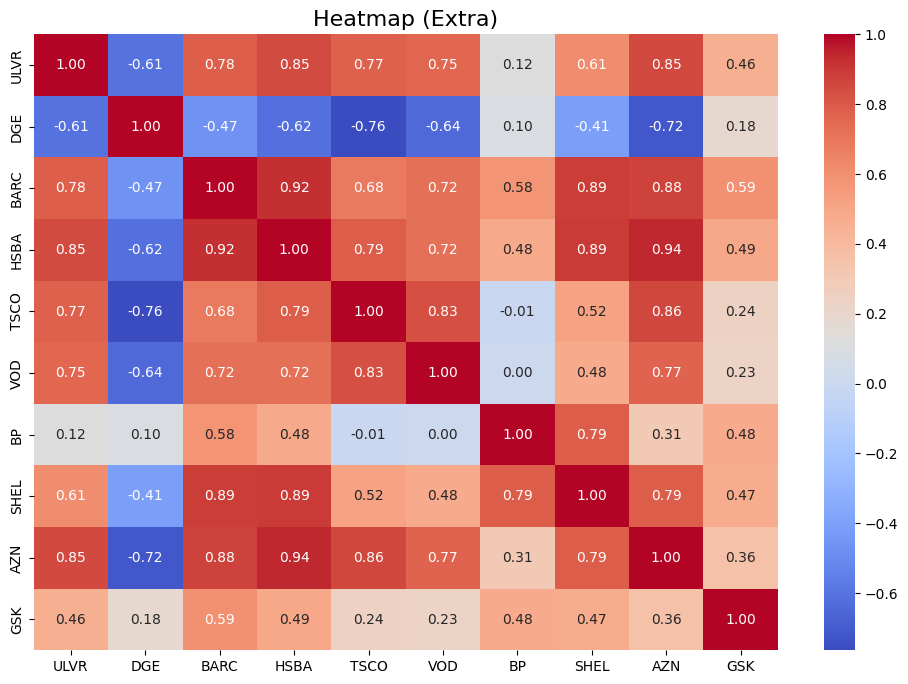


Log Returns (Extra):


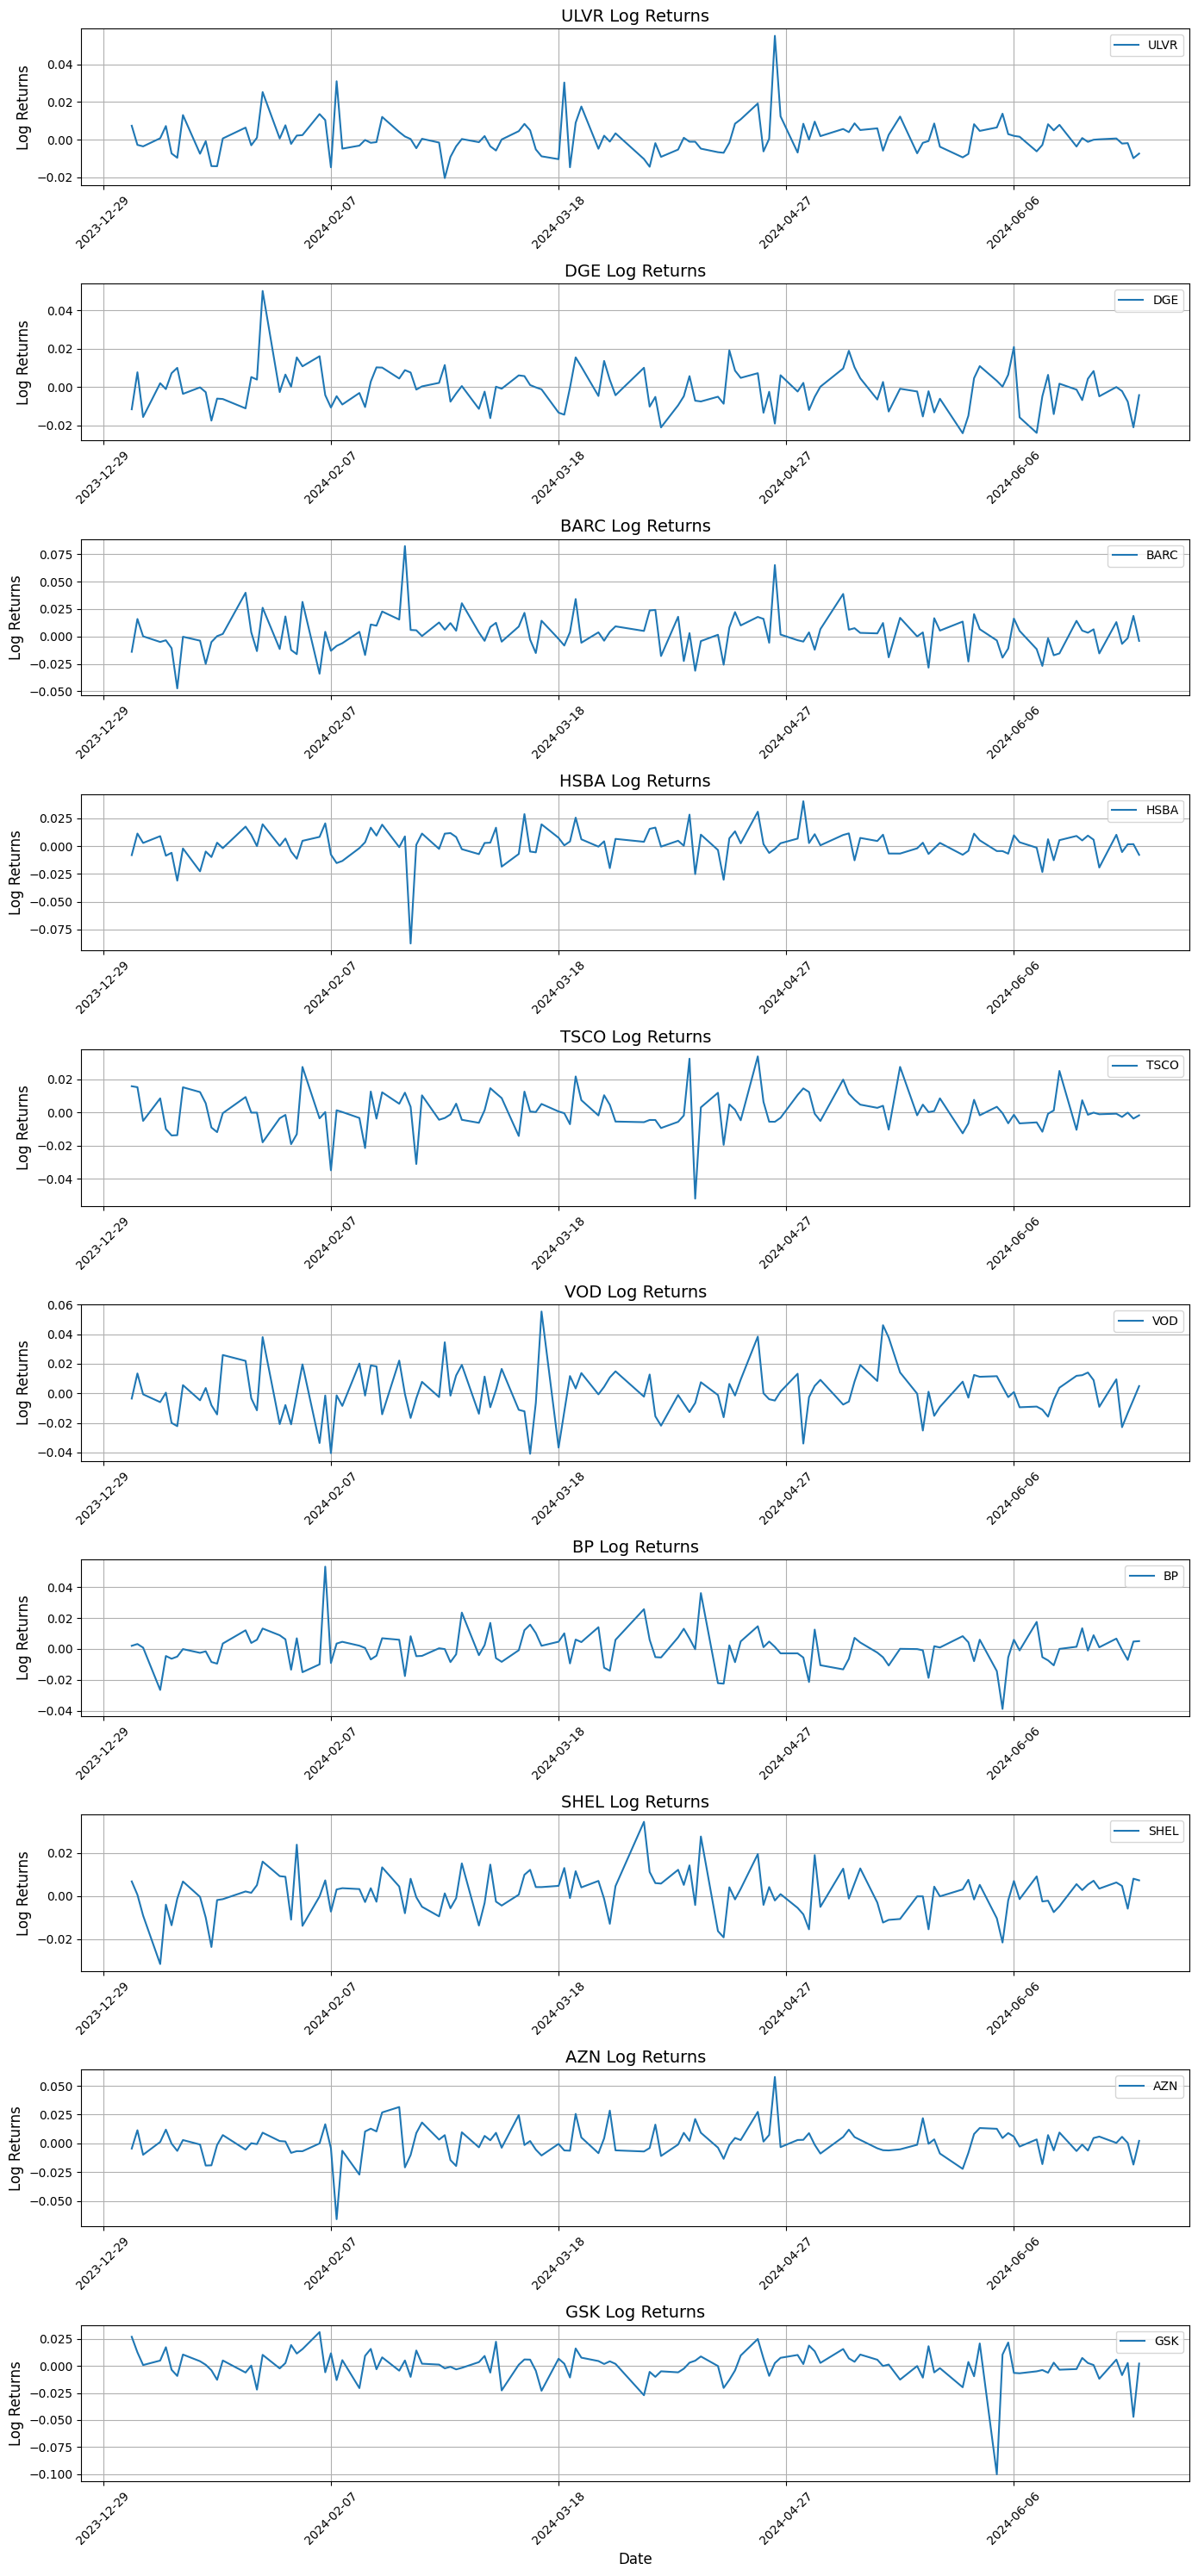


EDA completed.
Training data saved in output/train_data
Test data saved in output/test_data
Extra data saved in output/extra_data


In [11]:
# Function to perform Exploratory Data Analysis (EDA)
def perform_eda(df, data_type, output_dir):
    """
    Perform EDA on the DataFrame with proper formatting and spacing.

    Args:
    - df (pd.DataFrame): Combined stock data with multiple tickers.
    - data_type (str): A string indicating the type of data ('Train',
      'Test', or 'Extra').
    - output_dir (str): Directory to save output files.

    Returns:
    - None: Saves plots and Excel files to the specified directory.
    """
    # Check and create output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)

    # Display basic statistics of the dataset
    print(f"\nBasic Statistics ({data_type} Data):")
    basic_stats = df.describe()  # Generate descriptive statistics
    pd.options.display.float_format = "{:.2f}".format  # Format numbers to 2dp
    print(basic_stats)  # Print the statistics

    # Save basic statistics to Excel files, one for each column
    for column in basic_stats.columns:
        column_stats = basic_stats[[column]]
        column_stats.to_excel(
            os.path.join(output_dir,
                         f'basic_stats_{data_type.lower()}_{column}.xlsx')
        )

   # Perform EDA on the DataFrame
def perform_eda(df, data_type, output_dir):
    """
    Perform EDA on the DataFrame with
    proper formatting and spacing.
    """
    # Create output directory if not exists
    os.makedirs(output_dir, exist_ok=True)

    # Display basic statistics
    print(f"\nBasic Stats ({data_type}):")
    basic_stats = df.describe()
    pd.options.display.float_format = "{:.2f}".format
    print(basic_stats)

    # Save basic statistics to Excel
    for column in basic_stats.columns:
        column_stats = basic_stats[[column]]
        column_stats.to_excel(
            os.path.join(output_dir,
                         f'stats_{data_type.lower()}_{column}.xlsx')
        )

    # Check for missing values
    print(f"\nMissing Values ({data_type}):")
    missing_values = df.isnull().sum()
    print(missing_values)

    # Generate correlation matrix
    print(f"\nCorrelation Matrix ({data_type}):")
    corr_matrix = df.drop('Date', axis=1).corr()
    print(corr_matrix)

    # Plot correlation heatmap
    print(f"\nCorrelation Heatmap ({data_type}):")
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True,
                cmap='coolwarm', fmt=".2f")
    plt.title(f'Heatmap ({data_type})', fontsize=16)
    plt.savefig(os.path.join(output_dir,
                             f'heatmap_{data_type.lower()}.png'))
    plt.show()

    # Calculate log returns
    log_returns = np.log(df.set_index('Date')
                         .pct_change() + 1).dropna()

    # Begin plotting log returns over time
    print(f"\nLog Returns ({data_type}):")

    # Calculate the number of columns (tickers) minus 'Date'
    num_columns = len(df.columns) - 1

    # Create subplots, one for each column of log returns
    fig, axes = plt.subplots(num_columns, 1,
                             figsize=(14, 3 * num_columns),
                             sharex=False)

    # Adjust space between subplots
    fig.subplots_adjust(hspace=0.6)

    # Iterate over each column in log returns to create individual plots
    for i, column in enumerate(log_returns.columns):

       # Plot the log returns for the current column
        axes[i].plot(log_returns.index,
                     log_returns[column], label=column)

        # Set the title of the current subplot
        axes[i].set_title(f'{column} Log Returns', fontsize=14)

         # Label the y-axis of the current subplot
        axes[i].set_ylabel('Log Returns', fontsize=12)

        # Display a legend in the upper right corner
        axes[i].legend(loc='upper right')

        # Enable grid lines for better readability
        axes[i].grid(True)

        # Limit the number of x-axis ticks (dates) shown
        axes[i].xaxis.set_major_locator(
            plt.MaxNLocator(6))  # Limit date ticks

         # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=45)

    # Label the x-axis of the last subplot with 'Date'
    axes[-1].set_xlabel('Date', fontsize=12)

    # Adjust layout to prevent overlap of subplots and labels
    plt.tight_layout()

    # Save the figure as a PNG file in the specified directory
    plt.savefig(os.path.join(output_dir,
                             f'log_returns_{data_type.lower()}.png'))
    # Display the plot
    plt.show()


# Main function to execute the script
def main():
    """
    Main function to download, process,
    and analyze datasets.
    """
    # Define tickers for training data
    tickers_train = ['SVT.L', 'CCH.L', 'BATS.L',
                 'GLEN.L', 'LGEN.L']

    # Define tickers for test data
    tickers_test = ['RR.L', 'RTO.L', 'SGE.L',
                'LAND.L', 'SN.L']

    # Define tickers for extra test data
    tickers_extra = ['ULVR.L', 'DGE.L', 'BARC.L',
                 'HSBA.L', 'TSCO.L', 'VOD.L',
                 'BP.L', 'SHEL.L', 'AZN.L', 'GSK.L']

    # Define date range for training data
    date_train = ('2014-01-01', '2023-12-31')

    # Define date range for test data
    date_test = ('2024-01-01', '2024-03-31')

    # Define date range for extra test data
    date_extra = ('2024-01-01', '2024-06-30')

    # Set output directory for training data
    output_dir_train = 'output/train_data'

    # Set output directory for test data
    output_dir_test = 'output/test_data'

    # Set output directory for extra test data
    output_dir_extra = 'output/extra_data'

    # Download and process training data
    print("\nDownloading training data...")
    train_data = download_and_process_data(
    tickers_train, *date_train, output_dir_train)

    # Download and process test data
    print("\nDownloading test data...")
    test_data = download_and_process_data(
    tickers_test, *date_test, output_dir_test)

    # Download and process extra test data
    print("\nDownloading extra data...")
    extra_data = download_and_process_data(
    tickers_extra, *date_extra, output_dir_extra)

    # Perform EDA on training data
    print("\nPerforming EDA on training data...")
    perform_eda(train_data, 'Train', output_dir_train)

    # Perform EDA on test data
    print("\nPerforming EDA on test data...")
    perform_eda(test_data, 'Test', output_dir_test)

    # Perform EDA on extra test data
    print("\nPerforming EDA on extra data...")
    perform_eda(extra_data, 'Extra', output_dir_extra)

    # Print completion message for EDA
    print("\nEDA completed.")
    print(f"Training data saved in {output_dir_train}")
    print(f"Test data saved in {output_dir_test}")
    print(f"Extra data saved in {output_dir_extra}")

    # Save processed training data to CSV
    train_data.to_csv(os.path.join(output_dir_train,
                               'train_data.csv'), index=False)

    # Save processed test data to CSV
    test_data.to_csv(os.path.join(output_dir_test,
                              'test_data.csv'), index=False)

    # Save processed extra test data to CSV
    extra_data.to_csv(os.path.join(output_dir_extra,
                               'extra_data.csv'), index=False)

# Main function to run the script
if __name__ == "__main__":
    main()


In [42]:
from sklearn.preprocessing import RobustScaler, StandardScaler
import ta

# Set random seeds for reproducibility
set_random_seeds()

def preprocess_data(train_data, test_data, extra_data, n_lags=5,
                    output_dir='processed_data'):
    """
    Preprocess stock data, create lagged features,
    and save the processed data.
    Args:
    - train_data: Training dataset.
    - test_data: Test dataset.
    - extra_data: Extra test dataset.
    - n_lags: Number of lagged features.
    - output_dir: Directory for saving data.
    Returns:
    - dict: Dictionary with preprocessed data.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Dictionary to hold preprocessed data
    preprocessed_data = {'train': {},
                         'test': {},
                         'extra': {}}

    # Group datasets into a dictionary
    datasets = {'train': train_data,
                'test': test_data,
                'extra': extra_data}

    # Loop through datasets (train, test, extra)
    for name, data in datasets.items():
        print(f"Processing {name} data")

        # Ensure 'Date' is the index
        if data.index.name != 'Date':
            print(f"Indexing {name} by 'Date'")
            data['Date'] = pd.to_datetime(data['Date'])
            data.set_index('Date', inplace=True)

        # Loop through each stock ticker
        for ticker in data.columns:
            print(f"Processing {ticker}")
            stock_data = data[[ticker]].copy()

            # Calculate 20-day EMA
            stock_data['EMA_20'] = ta.trend.ema_indicator(
                stock_data[ticker], window=20
            )
            # Calculate 14-day RSI
            stock_data['RSI'] = ta.momentum.rsi(
                stock_data[ticker], window=14
            )
            # Calculate MACD
            stock_data['MACD'] = ta.trend.macd(
                stock_data[ticker]
            )

            # Create lagged features
            available_rows = len(stock_data) - n_lags
            if available_rows <= 0:
                print(f"Not enough data for {n_lags} lags.")
                n_lags = len(stock_data) - 1

            for lag in range(1, n_lags + 1):
                stock_data[f'{ticker}_lag_{lag}'] = stock_data[
                    ticker
                ].shift(lag)

            # Drop rows with missing values
            stock_data.dropna(inplace=True)

            if stock_data.empty:
                print(f"No data left for {ticker} in {name}.")
                continue

            # Separate features (X) and target (y)
            X = stock_data.drop(columns=[ticker])
            y = stock_data[ticker]

            # Initialize scalers: Robust for X, Standard for y
            feature_scaler = RobustScaler()
            target_scaler = StandardScaler()

            # Scale features and target
            X_scaled = feature_scaler.fit_transform(X)
            y_scaled = target_scaler.fit_transform(
                y.values.reshape(-1, 1)
            ).flatten()

            # Convert scaled data to DataFrame and Series
            X_scaled = pd.DataFrame(X_scaled, columns=X.columns,
                                    index=X.index)
            y_scaled = pd.Series(y_scaled, index=y.index)

            # Store scaled data and scalers
            preprocessed_data[name][ticker] = {
                'X': X_scaled,
                'y': y_scaled,
                'feature_scaler': feature_scaler,
                'target_scaler': target_scaler
            }

            # Save features and target to CSV
            X_scaled.to_csv(os.path.join(output_dir,
                                         f'{name}_{ticker}_X.csv'))
            y_scaled.to_csv(os.path.join(output_dir,
                                         f'{name}_{ticker}_y.csv'))
            # Save scalers for future use
            joblib.dump(feature_scaler,
                        os.path.join(output_dir,
                                     f'{name}_{ticker}_feature_scaler.pkl'))
            joblib.dump(target_scaler,
                        os.path.join(output_dir,
                                     f'{name}_{ticker}_target_scaler.pkl'))

    # Print final shapes of preprocessed data
    print("\nFinal shapes of preprocessed data:")
    for name, dataset in preprocessed_data.items():
        print(f"\n{name.capitalize()} data:")
        for ticker, data in dataset.items():
            print(f"  {ticker}: X shape {data['X'].shape}, \n"
                  f"y shape {data['y'].shape}")

    return preprocessed_data

# Define directories for saving processed data
output_dir_train = 'output/train_data'
output_dir_test = 'output/test_data'
output_dir_extra = 'output/extra_data'

# Load datasets from CSV files
combined_train_data = pd.read_csv(
    os.path.join(output_dir_train, 'train_data.csv')
)
combined_test_data = pd.read_csv(
    os.path.join(output_dir_test, 'test_data.csv')
)
combined_extra_test_data = pd.read_csv(
    os.path.join(output_dir_extra, 'extra_data.csv')
)

# Display a preview of the datasets
print("Train Data:")
print(combined_train_data.head())
print("\nTest Data:")
print(combined_test_data.head())
print("\nExtra Test Data:")
print(combined_extra_test_data.head())

# Preprocess datasets
preprocessed_data = preprocess_data(
    combined_train_data, combined_test_data,
    combined_extra_test_data
)


Train Data:
         Date     SVT     CCH    BATS   GLEN   LGEN
0  2014-01-02 1098.84 1241.76 1680.69 208.17 111.72
1  2014-01-03 1109.22 1215.69 1676.76 206.16 111.67
2  2014-01-06 1105.33 1236.13 1679.64 205.36 113.32
3  2014-01-07 1081.32 1268.54 1669.16 207.07 114.83
4  2014-01-08 1061.86 1254.45 1652.92 211.06 113.93

Test Data:
         Date     RR    RTO     SGE   LAND      SN
0  2024-01-02 298.10 424.12 1145.12 685.24 1043.87
1  2024-01-03 294.80 403.13 1131.36 674.22 1026.27
2  2024-01-04 297.80 405.97 1127.92 673.45 1027.73
3  2024-01-05 296.60 404.01 1118.10 672.09 1018.93
4  2024-01-08 305.20 406.66 1130.38 675.96 1046.80

Extra Test Data:
         Date    ULVR     DGE   BARC   HSBA   TSCO   VOD     BP    SHEL  \
0  2024-01-02 3729.05 2789.42 148.44 572.18 285.32 65.66 451.63 2486.36   
1  2024-01-03 3756.84 2757.27 146.37 567.55 289.89 65.43 452.55 2503.26   
2  2024-01-04 3746.60 2778.54 148.73 574.00 294.37 66.31 453.98 2504.71   
3  2024-01-05 3733.44 2735.50 148.74 575

In [52]:
def preprocess_and_combine_train_data(preprocessed_data):
    """
    Combine training data across tickers.

    Args:
    - preprocessed_data: Preprocessed training data.

    Returns:
    - X_train_combined: Combined features.
    - y_train_combined: Combined targets.
    """
    # Initialize lists to store combined data
    X_train_combined = []
    y_train_combined = []

    # Loop through each ticker's data
    for ticker, data in preprocessed_data['train'].items():
        # Append features to the combined list
        X_train_combined.append(data['X'].values)
        # Append targets to the combined list
        y_train_combined.append(data['y'].values)

    # Stack features vertically to combine
    X_train_combined = np.vstack(X_train_combined)
    # Stack targets horizontally to combine
    y_train_combined = np.hstack(y_train_combined)

    # Return the combined features and targets
    return X_train_combined, y_train_combined

# Combine preprocessed training data
X_train_combined, y_train_combined = preprocess_and_combine_train_data(preprocessed_data)


In [54]:
print(X_train_bilstm.shape )

(12426, 10, 7)


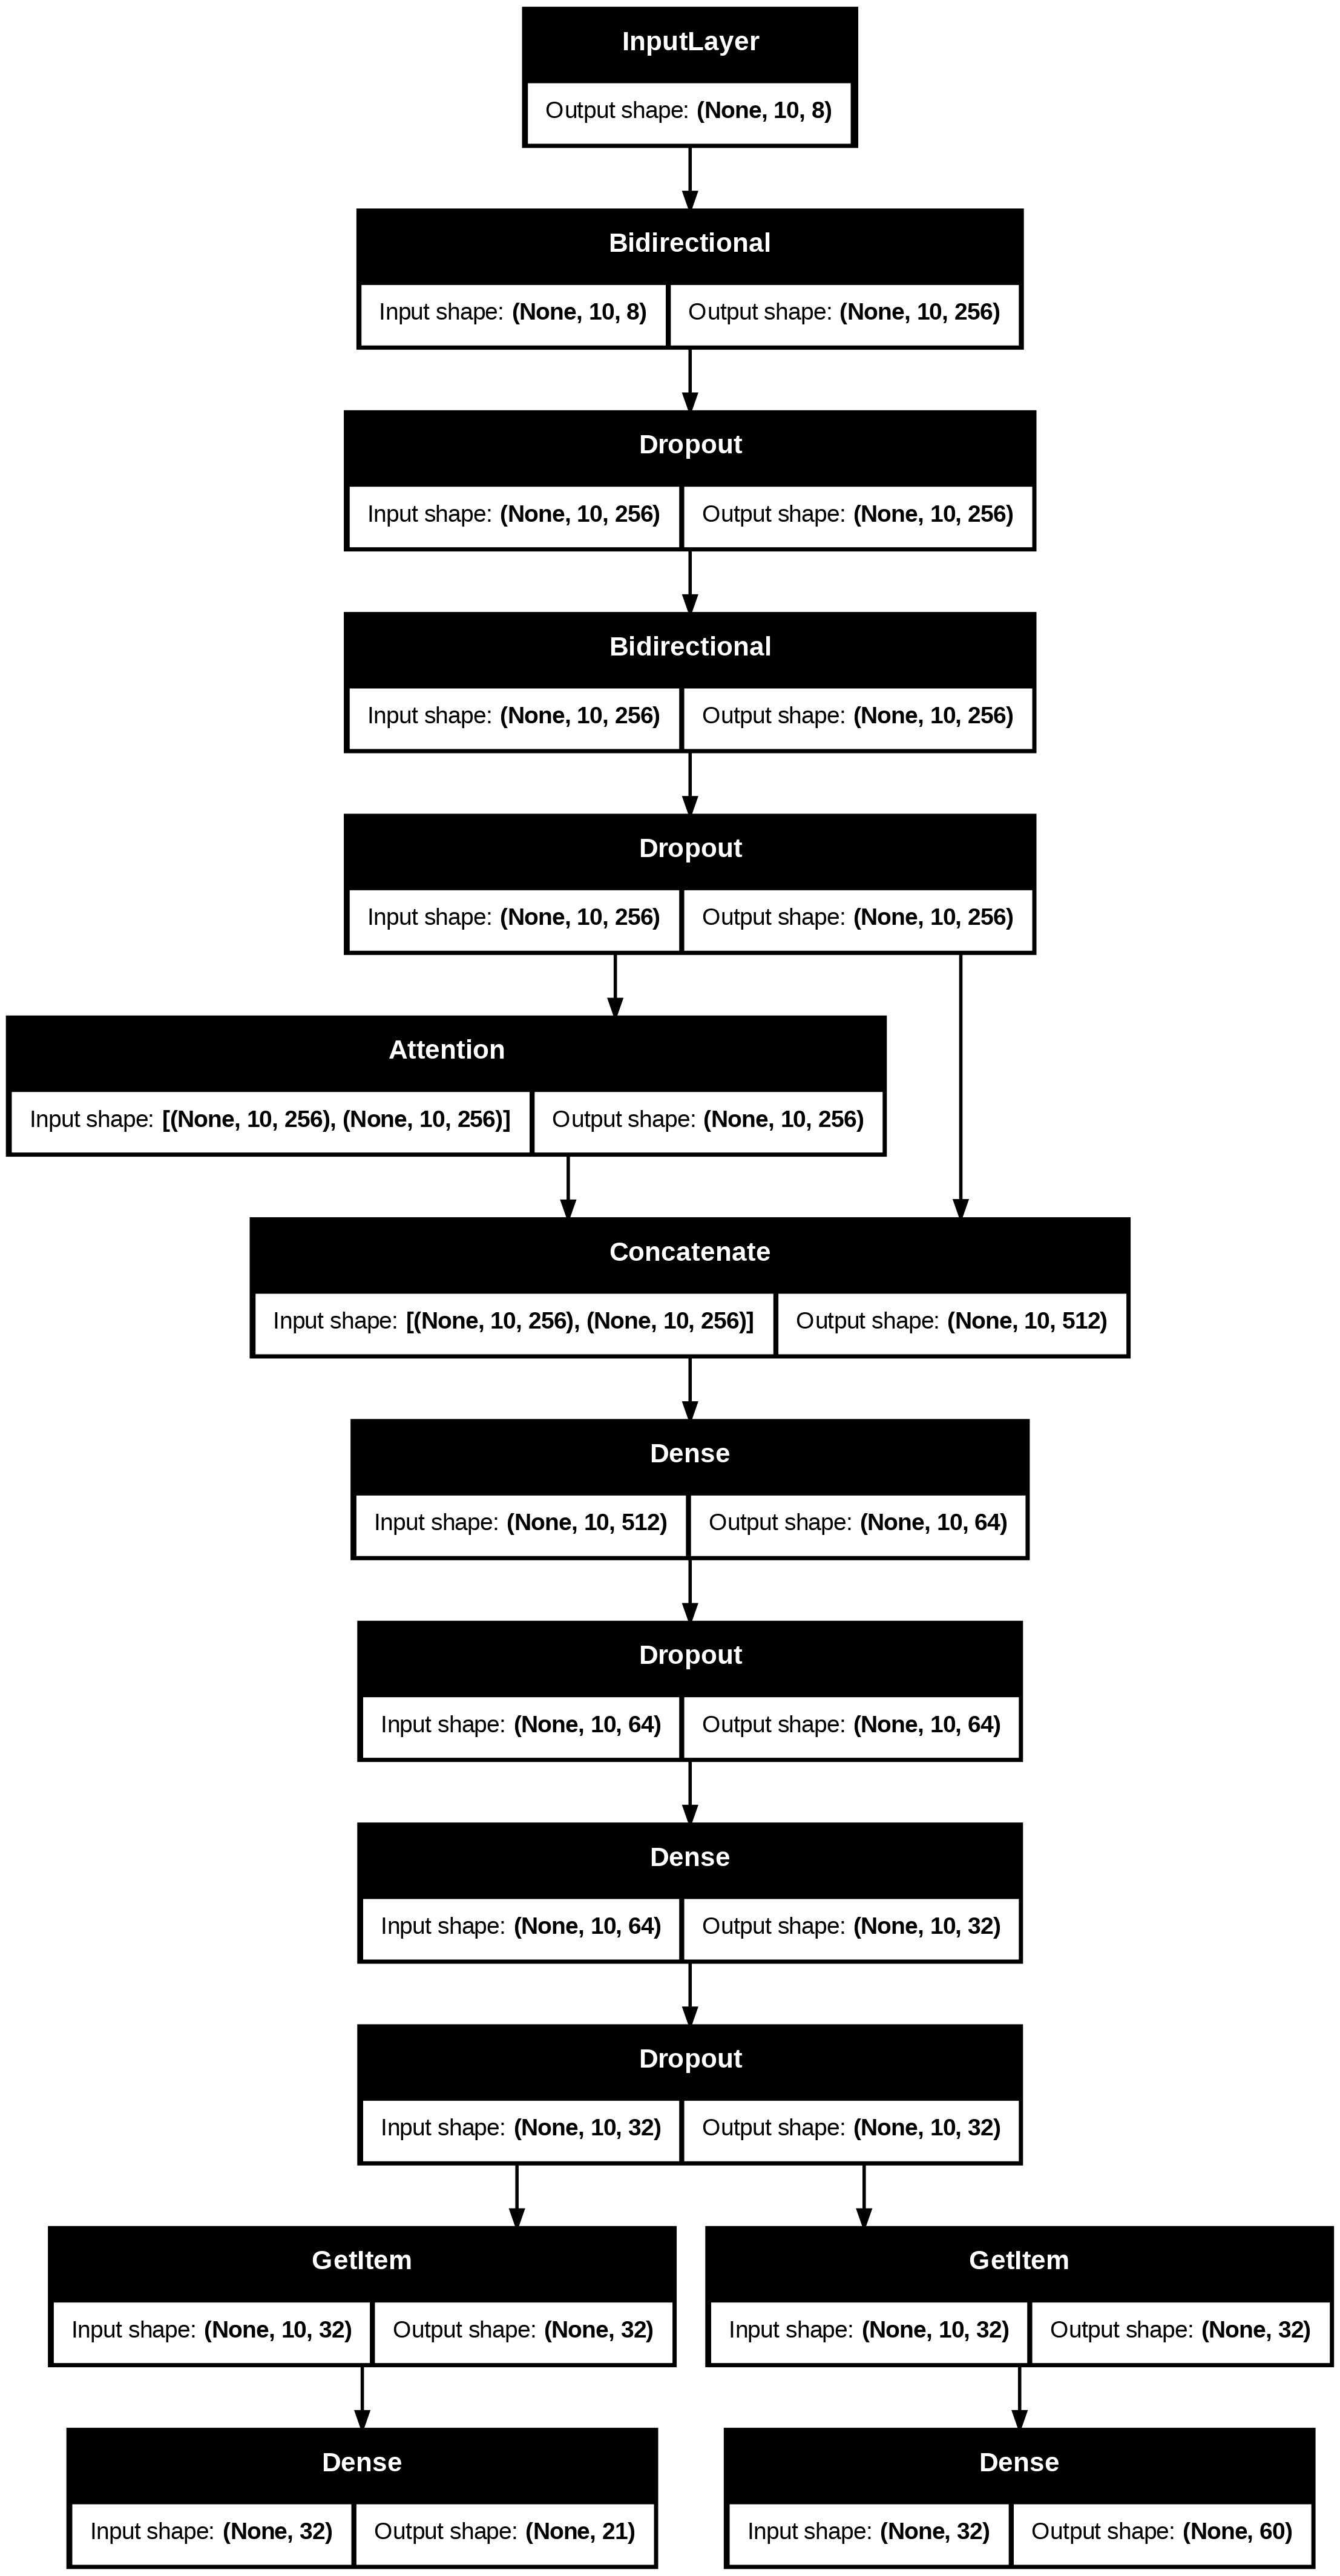

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 8)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 10, 256)        │        140,288 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 10, 256)        │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 10, 256)        │        394,240 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 10, 256)        │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 10, 256)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 10, 512)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10, 64)         │         32,832 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 10, 64)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 10, 32)         │          2,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 10, 32)         │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 32)             │              0 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 32)             │              0 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 21)             │            693 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 60)             │          1,980 │ get_item_1[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 572,113 (2.18 MB)

 Trainable params: 572,113 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Initialize random seeds for reproducibility
set_random_seeds()

def prepare_data_for_bilstm(features, targets, input_window_size,
                            forecast_horizon_21, forecast_horizon_60):
    """
    Prepare data for the BiLSTM model.
    Args:
    - features: Feature set (DataFrame).
    - targets: Target variable (Series).
    - input_window_size: Time steps for input.
    - forecast_horizon_21: 21-day horizon.
    - forecast_horizon_60: 60-day horizon.
    Returns:
    - X: Feature sequences (array).
    - y_21: Target sequences for 21-day.
    - y_60: Target sequences for 60-day.
    """
    # Initialize lists for sequences
    X, y_21, y_60 = [], [], []

    # Loop through to create sequences
    for i in range(len(features) - input_window_size -
                   max(forecast_horizon_21, forecast_horizon_60) + 1):
        # Extract feature sequences
        X.append(features.iloc[i:i+input_window_size].values)
        # Extract target sequences for 21-day
        y_21.append(targets.iloc[i+input_window_size:
                                 i+input_window_size+forecast_horizon_21].values)
        # Extract target sequences for 60-day
        y_60.append(targets.iloc[i+input_window_size:
                                 i+input_window_size+forecast_horizon_60].values)

    # Convert lists to numpy arrays
    return np.array(X), np.array(y_21), np.array(y_60)


def build_bilstm_attention_model(input_shape, forecast_horizon_21,
                                 forecast_horizon_60):
    """
    Build BiLSTM model with attention.
    Args:
    - input_shape: Shape of input data(10, 8)
    - forecast_horizon_21: 21-day prediction steps.
    - forecast_horizon_60: 60-day prediction steps.
    Returns:
    - model: Compiled BiLSTM model.
    """
    # Define the input layer
    inputs = Input(shape=(10,8))

    # Add first bidirectional LSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Dropout(0.25)(x)  # Add dropout for regularization

    # Add second bidirectional LSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.25)(x)  # Another dropout layer

    # Add attention mechanism
    attention = Attention()([x, x])
    # Concatenate attention output with LSTM
    x = Concatenate()([x, attention])

    # Add dense layer with activation and dropout
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Add another dense layer with activation and dropout
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Define the output layers for 21-day and 60-day
    output_21 = Dense(forecast_horizon_21)(x[:, -1, :])
    output_60 = Dense(forecast_horizon_60)(x[:, -1, :])

    # Combine inputs and outputs in the model
    model = Model(inputs=inputs, outputs=[output_21, output_60])

    # Compile the model with Adam optimizer and MSE loss
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='mse',
                  metrics=[MeanAbsoluteError(), MeanAbsoluteError()])

    return model


# Prepare training data for the BiLSTM model
X_train_bilstm, y_train_bilstm_21, y_train_bilstm_60 = prepare_data_for_bilstm(
    pd.DataFrame(X_train_combined),
    pd.Series(y_train_combined),
    input_window_size=10,  # Set input window size
    forecast_horizon_21=21,  # Set 21-day forecast horizon
    forecast_horizon_60=60  # Set 60-day forecast horizon
)

# Prepare test data for each ticker
X_test_tickerwise, y_test_tickerwise = {}, {}
for ticker, data in preprocessed_data['test'].items():
    # Prepare test data sequences
    X_test, y_test_21, y_test_60 = prepare_data_for_bilstm(
        data['X'], data['y'], input_window_size=10,
        forecast_horizon_21=21, forecast_horizon_60=60
    )
    # Store the prepared test data in dictionaries
    X_test_tickerwise[ticker] = X_test
    y_test_tickerwise[ticker] = {'21': y_test_21, '60': y_test_60}

# Prepare extra data for each ticker
X_extra_tickerwise, y_extra_tickerwise = {}, {}
for ticker, data in preprocessed_data['extra'].items():
    # Prepare extra data sequences
    X_extra, y_extra_21, y_extra_60 = prepare_data_for_bilstm(
        data['X'], data['y'], input_window_size=10,
        forecast_horizon_21=21, forecast_horizon_60=60
    )
    # Store the prepared extra data in dictionaries
    X_extra_tickerwise[ticker] = X_extra
    y_extra_tickerwise[ticker] = {'21': y_extra_21, '60': y_extra_60}




# Clear the session to reset layer names
clear_session()

# Define the input shape using your training data
input_shape = (10, 8)

# Build the BiLSTM model with attention mechanism
model = build_bilstm_attention_model(input_shape,
                                     forecast_horizon_21=21,
                                     forecast_horizon_60=60)

# Plot and display the model architecture
plot_model(model, to_file='bilstm_attention_model.png',
           show_shapes=True)
display(Image(filename='bilstm_attention_model.png'))

# Display the model summary to understand its structure
model.summary()


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - dense_2_mean_absolute_error: 0.6450 - dense_3_mean_absolute_error: 0.7008 - loss: 1.2691
Epoch 1: val_loss improved from inf to 1.42620, saving model to best_bilstm_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - dense_2_mean_absolute_error: 0.6438 - dense_3_mean_absolute_error: 0.7001 - loss: 1.2672 - val_dense_2_mean_absolute_error: 0.6407 - val_dense_3_mean_absolute_error: 0.7594 - val_loss: 1.4262
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - dense_2_mean_absolute_error: 0.4078 - dense_3_mean_absolute_error: 0.4835 - loss: 0.6953
Epoch 2: val_loss improved from 1.42620 to 0.90359, saving model to best_bilstm_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - dense_2_mean_absolute_error: 0.4074 - dense_3_mean_absolute_error: 0.4829 - loss: 0.6942 - val_dense_2_mean_absolute_error: 0.5028 - val_dense_3_mean_absolute_error: 0.5915 - val_loss: 0.9036
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - dense_2_mean

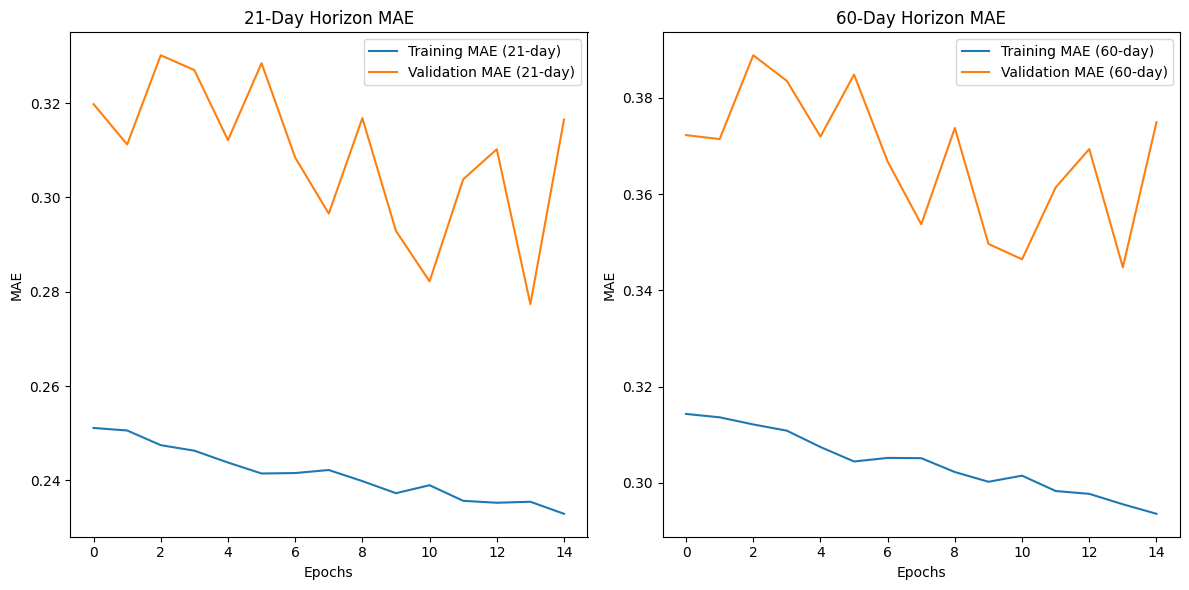

In [62]:
# Initialize seeds for reproducibility
set_random_seeds()

def train_bilstm_model(model, X, y_21, y_60, model_name):
    """
    Train BiLSTM model with time series
    cross-validation and early stopping.
    Args:
    - model: Compiled BiLSTM model to train.
    - X: Feature set for BiLSTM (np.array).
    - y_21: Target set for 21-day horizon.
    - y_60: Target set for 60-day horizon.
    - model_name: Name for saving the model.
    Returns:
    - model: Trained BiLSTM model.
    - histories: Training history for analysis.
    """
    # Checkpoint to save best model
    checkpoint = ModelCheckpoint(f'best_{model_name}.keras',
                                 monitor='val_loss',
                                 save_best_only=True, verbose=1)

    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=15,
                                   verbose=1,
                                   restore_best_weights=True)

    # Initialize time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    all_histories = []  # Store training history

    # Loop through each cross-validation split
    for train_index, val_index in tscv.split(X):
        # Split data into training and validation sets
        X_train, X_val = X[train_index], X[val_index]
        y_train_21, y_val_21 = y_21[train_index], y_21[val_index]
        y_train_60, y_val_60 = y_60[train_index], y_60[val_index]

        # Train model on both 21-day and 60-day targets
        history = model.fit(X_train, [y_train_21, y_train_60],
                            epochs=100, batch_size=32,
                            validation_data=(X_val, [y_val_21, y_val_60]),
                            callbacks=[checkpoint, early_stopping])

        # Append the history of the current split
        all_histories.append(history.history)

    # Save the trained model using joblib
    joblib.dump(model, f'{model_name}.joblib')

    return model, all_histories

# Train the BiLSTM model
model, histories = train_bilstm_model(model,
                                      X_train_bilstm,
                                      y_train_bilstm_21,
                                      y_train_bilstm_60,
                                      'bilstm_model')

# Plot training history for 21-day and 60-day
plt.figure(figsize=(12, 6))

# Plot 21-day horizon MAE
plt.subplot(1, 2, 1)
plt.plot(histories[-1]['dense_2_mean_absolute_error'],
         label='Training MAE (21-day)')
plt.plot(histories[-1]['val_dense_2_mean_absolute_error'],
         label='Validation MAE (21-day)')
plt.title('21-Day Horizon MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot 60-day horizon MAE
plt.subplot(1, 2, 2)
plt.plot(histories[-1]['dense_3_mean_absolute_error'],
         label='Training MAE (60-day)')
plt.plot(histories[-1]['val_dense_3_mean_absolute_error'],
         label='Validation MAE (60-day)')
plt.title('60-Day Horizon MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()


In [75]:
def fine_tune_model_on_individual_stock(model, X, y_21, y_60, model_name, ticker):
    """
    Fine-tune BiLSTM model on individual stock's data with time series
    cross-validation and early stopping.
    Args:
    - model: Compiled BiLSTM model to fine-tune.
    - X: Feature set for BiLSTM (np.array) for the specific ticker.
    - y_21: Target set for 21-day horizon for the specific ticker.
    - y_60: Target set for 60-day horizon for the specific ticker.
    - model_name: Name for saving the fine-tuned model.
    - ticker: Ticker symbol to include in the model name.
    Returns:
    - fine_tuned_model: Fine-tuned BiLSTM model for the specific ticker.
    - histories: Training history for analysis.
    """
    # Checkpoint to save best model
    checkpoint = ModelCheckpoint(f'best_{model_name}_{ticker}.keras',
                                 monitor='val_loss',
                                 save_best_only=True, verbose=1)

    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=15,
                                   verbose=1,
                                   restore_best_weights=True)

    # Initialize time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    all_histories = []  # Store training history

    # Loop through each cross-validation split
    for train_index, val_index in tscv.split(X):
        # Split data into training and validation sets
        X_train, X_val = X[train_index], X[val_index]
        y_train_21, y_val_21 = y_21[train_index], y_21[val_index]
        y_train_60, y_val_60 = y_60[train_index], y_60[val_index]

        # Train model on both 21-day and 60-day targets
        history = model.fit(X_train, [y_train_21, y_train_60],
                            epochs=100, batch_size=32,
                            validation_data=(X_val, [y_val_21, y_val_60]),
                            callbacks=[checkpoint, early_stopping])

        # Append the history of the current split
        all_histories.append(history.history)

    # Save the fine-tuned model using joblib
    joblib.dump(model, f'{model_name}_{ticker}.joblib')

    return model, all_histories

# Fine-tune the BiLSTM model for each ticker in the training dataset
for ticker in tickers_train:
    print(f"Fine-tuning model for {ticker}...")

    # Retrieve individual stock data from the training dataset
    X_individual = X_train_tickerwise[ticker]
    y_individual_21 = y_train_tickerwise[ticker]['21']
    y_individual_60 = y_train_tickerwise[ticker]['60']

    # Fine-tune the model on this individual stock's data
    fine_tuned_model, histories = fine_tune_model_on_individual_stock(
        model, X_individual, y_individual_21, y_individual_60,
        'bilstm_model', ticker
    )

    print(f"Fine-tuning complete for {ticker}.\n")


NameError: name 'tickers_train' is not defined

In [71]:
def evaluate_and_plot_model(model, preprocessed_data, model_name,
                            input_window_size, forecast_horizon_21,
                            forecast_horizon_60, output_dir):
    """
    Evaluate a model on test and extra test sets,
    save results, and generate visualizations.

    Args:
    - model: The trained model to evaluate.
    - preprocessed_data: The preprocessed data dictionary.
    - model_name: Name of the model (e.g., 'BiLSTM').
    - input_window_size: The input window size.
    - forecast_horizon_21: 21-day forecast horizon.
    - forecast_horizon_60: 60-day forecast horizon.
    - output_dir: Directory to save results and plots.

    Returns:
    - None: Results are saved and plots are displayed.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Lists to store evaluation metrics
    results_test = []
    results_extra = []

    # Evaluate on the test set (21-day horizon)
    for ticker in preprocessed_data['test'].keys():
        print(f"Evaluating {ticker} for 21-day horizon")

        # Prepare test data
        X_test, y_test, _ = prepare_data_for_bilstm(
            preprocessed_data['test'][ticker]['X'],
            preprocessed_data['test'][ticker]['y'],
            input_window_size=input_window_size,
            forecast_horizon_21=forecast_horizon_21,
            forecast_horizon_60=0  # Only 21-day horizon
        )

        # Predict on test set
        y_pred_test = model.predict(X_test)[0]  # 21-day output

        # Inverse transform predictions
        test_scaler = preprocessed_data['test'][ticker]['target_scaler']
        y_pred_unscaled = test_scaler.inverse_transform(y_pred_test)
        y_true_unscaled = test_scaler.inverse_transform(y_test)

        # Calculate evaluation metrics
        rmse_test = np.sqrt(mean_squared_error(y_true_unscaled, y_pred_unscaled))
        mae_test = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
        r2_test = r2_score(y_true_unscaled, y_pred_unscaled)

        # Save results for this ticker
        results_test.append({
            'Ticker': ticker,
            'RMSE': rmse_test,
            'MAE': mae_test,
            'R2': r2_test
        })

        # Plot time step for test set
        plt.figure(figsize=(10, 6))
        plt.plot(y_true_unscaled, label='Actual')
        plt.plot(y_pred_unscaled, label='Predicted')
        plt.title(f'{ticker} - 21-Day Horizon')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.savefig(os.path.join(output_dir,
                    f'{ticker}_21_day_time_step_plot.png'))
        plt.show()

    # Evaluate on the extra test set (60-day horizon)
    for ticker in preprocessed_data['extra'].keys():
        print(f"Evaluating {ticker} for 60-day horizon")

        # Prepare extra test data
        X_extra, _, y_extra = prepare_data_for_bilstm(
            preprocessed_data['extra'][ticker]['X'],
            preprocessed_data['extra'][ticker]['y'],
            input_window_size=input_window_size,
            forecast_horizon_21=0,  # Only 60-day horizon
            forecast_horizon_60=forecast_horizon_60
        )

        # Predict on extra test set
        y_pred_extra = model.predict(X_extra)[1]  # 60-day output

        # Inverse transform predictions
        extra_scaler = preprocessed_data['extra'][ticker]['target_scaler']
        y_pred_unscaled = extra_scaler.inverse_transform(y_pred_extra)
        y_true_unscaled = extra_scaler.inverse_transform(y_extra)

        # Calculate evaluation metrics
        rmse_extra = np.sqrt(mean_squared_error(y_true_unscaled, y_pred_unscaled))
        mae_extra = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
        r2_extra = r2_score(y_true_unscaled, y_pred_unscaled)

        # Save results for this ticker
        results_extra.append({
            'Ticker': ticker,
            'RMSE': rmse_extra,
            'MAE': mae_extra,
            'R2': r2_extra
        })

        # Plot time step for extra test set
        plt.figure(figsize=(10, 6))
        plt.plot(y_true_unscaled, label='Actual')
        plt.plot(y_pred_unscaled, label='Predicted')
        plt.title(f'{ticker} - 60-Day Horizon')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.savefig(os.path.join(output_dir,
                    f'{ticker}_60_day_time_step_plot.png'))
        plt.show()

    # Convert results to DataFrame
    results_test_df = pd.DataFrame(results_test)
    results_extra_df = pd.DataFrame(results_extra)

    # Save the results to CSV files
    results_test_df.to_csv(os.path.join(output_dir,
                                        f'{model_name}_test_results.csv'),
                            index=False)
    results_extra_df.to_csv(os.path.join(output_dir,
                                         f'{model_name}_extra_results.csv'),
                             index=False)

    print("Results saved successfully in CSV format.")



In [73]:


def plot_ulvr_results(y_true_unscaled, y_pred_unscaled, ticker='ULVR', horizon='60-Day'):
    """
    Plot actual vs. predicted values for a specific ticker and horizon.

    Args:
    - y_true_unscaled: Actual values (numpy array).
    - y_pred_unscaled: Predicted values (numpy array).
    - ticker: Stock ticker (string).
    - horizon: Prediction horizon (string).
    """
    # Select a subset of predictions to plot (e.g., every 10th prediction)
    step = 10
    indices = np.arange(0, y_true_unscaled.shape[0], step)

    # Create a new figure for the plot
    plt.figure(figsize=(10, 6))

    # Plot the actual values
    plt.plot(y_true_unscaled[:, 0], label='Actual', color='blue')

    # Plot a subset of the predicted values
    for i in indices:
        plt.plot(y_pred_unscaled[i, :], label=f'Predicted {i}', linestyle='--', alpha=0.7)

    # Add title and labels
    plt.title(f'{ticker} - {horizon} Horizon')
    plt.xlabel('Time Step')
    plt.ylabel('Value')

    # Adjust the legend
    plt.legend(loc='upper right', fontsize='small', ncol=2)

    # Show the plot
    plt.show()

# Example usage:
plot_ulvr_results(y_true_unscaled_ULVR, y_pred_unscaled_ULVR, ticker='ULVR', horizon='60-Day')


NameError: name 'y_true_unscaled_ULVR' is not defined

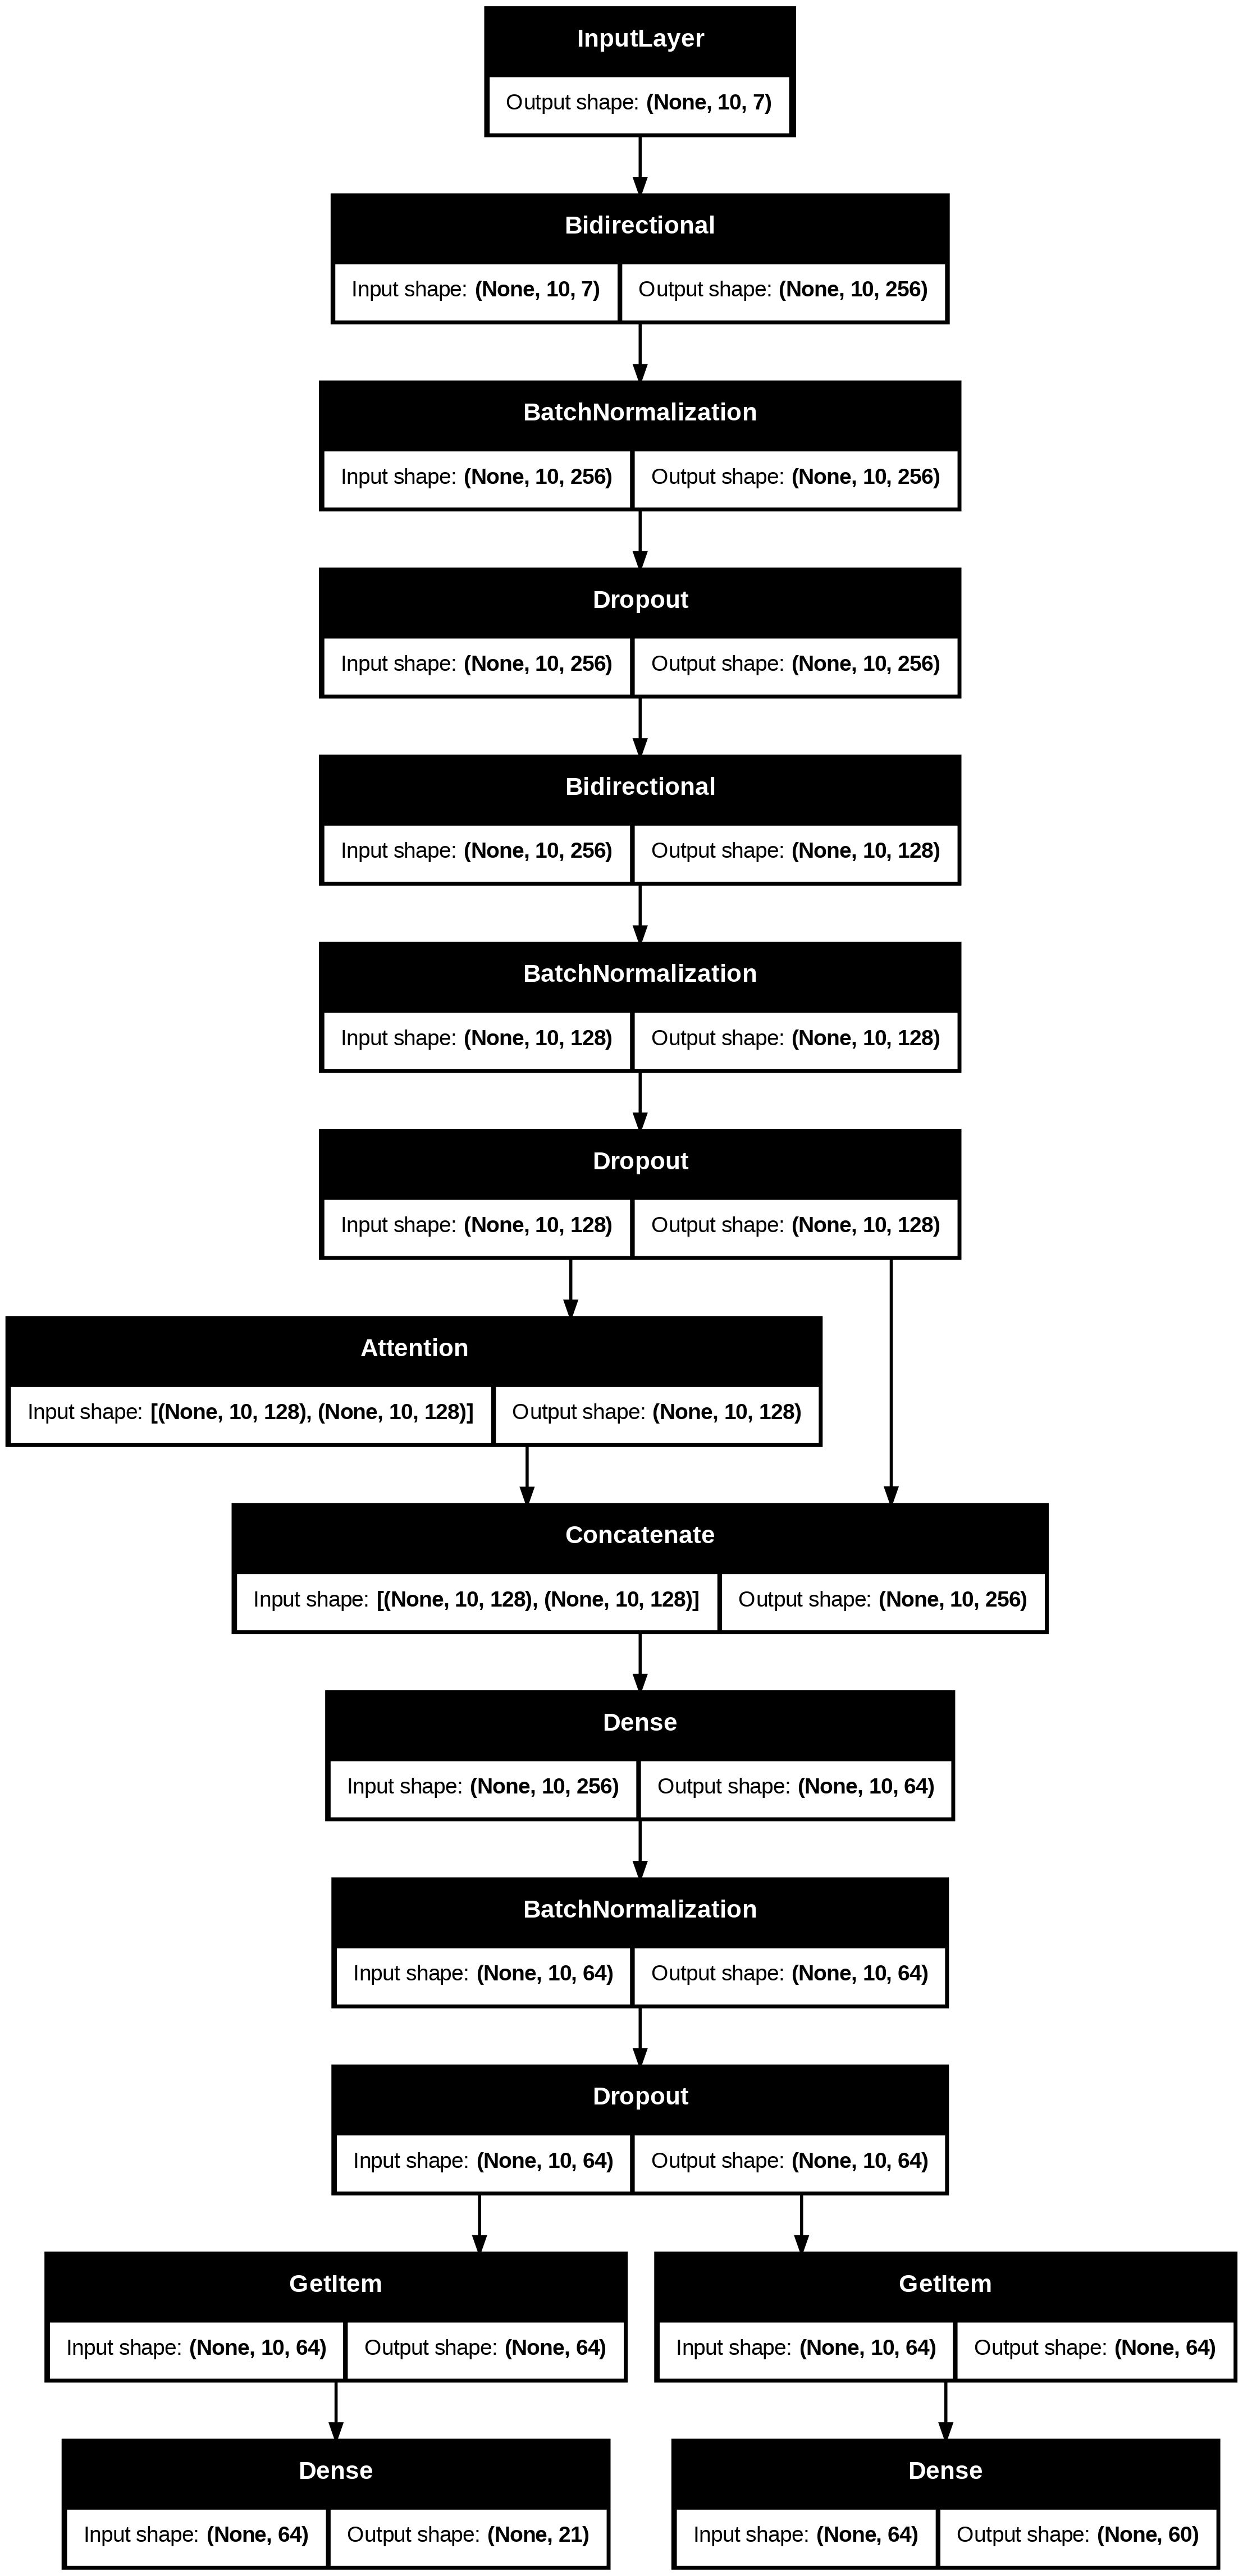

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32            │ (None, 10, 7)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_64          │ (None, 10, 256)        │        139,264 │ input_layer_32[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 10, 256)        │          1,024 │ bidirectional_64[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_96 (Dropout)      │ (None, 10, 256)        │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_65          │ (None, 10, 128)        │        164,352 │ dropout_96[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 10, 128)        │            512 │ bidirectional_65[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_97 (Dropout)      │ (None, 10, 128)        │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_32 (Attention)  │ (None, 10, 128)        │              0 │ dropout_97[0][0],      │
│                           │                        │                │ dropout_97[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_32            │ (None, 10, 256)        │              0 │ dropout_97[0][0],      │
│ (Concatenate)             │                        │                │ attention_32[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_85 (Dense)          │ (None, 10, 64)         │         16,448 │ concatenate_32[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 10, 64)         │            256 │ dense_85[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_98 (Dropout)      │ (None, 10, 64)         │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_53 (GetItem)     │ (None, 64)             │              0 │ dropout_98[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_54 (GetItem)     │ (None, 64)             │              0 │ dropout_98[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_86 (Dense)          │ (None, 21)             │          1,365 │ get_item_53[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_87 (Dense)     

 Total params: 327,121 (1.25 MB)

 Trainable params: 326,225 (1.24 MB)

 Non-trainable params: 896 (3.50 KB)

In [200]:


# Initialize random seeds for reproducibility
set_random_seeds()

def prepare_data_for_bilstm(features, targets, input_window_size,
                            forecast_horizon_21, forecast_horizon_60):
    """
    Prepares the data for the BiLSTM model by creating sequences of input_window_size.
    """
    X, y_21, y_60 = [], [], []

    for i in range(len(features) - input_window_size - max(forecast_horizon_21,
                                                           forecast_horizon_60) + 1):
        X.append(features.iloc[i:i+input_window_size].values)
        y_21.append(targets.iloc[i+input_window_size:i+input_window_size+forecast_horizon_21].values)
        y_60.append(targets.iloc[i+input_window_size:i+input_window_size+forecast_horizon_60].values)

    return np.array(X), np.array(y_21), np.array(y_60)

def build_bilstm_attention_model_ht(input_shape, forecast_horizon_21, forecast_horizon_60):
    """
    Build a BiLSTM model with attention and regularization for multi-horizon forecasting.
    """
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM layers with increased dropout and L2 regularization
    x = Bidirectional(LSTM(128, return_sequences=True,
                           kernel_regularizer=l2(5e-5)))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Bidirectional(LSTM(64, return_sequences=True,
                           kernel_regularizer=l2(5e-5)))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Attention mechanism to focus on relevant parts of the sequence
    attention = Attention()([x, x])
    x = Concatenate()([x, attention])

    # Dense layer with increased dropout and L2 regularization
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Output layers for both horizons
    output_21 = Dense(forecast_horizon_21,
                      kernel_regularizer=l2(0.01))(x[:, -1, :])
    output_60 = Dense(forecast_horizon_60,
                      kernel_regularizer=l2(0.01))(x[:, -1, :])

    # Combine the outputs
    model = Model(inputs=inputs, outputs=[output_21, output_60])

   # Use a learning rate schedule
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001,
                                   decay_steps=10000, decay_rate=0.9)
    optimizer = Adam(clipnorm=1.0)

    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=[MeanAbsoluteError(), MeanAbsoluteError()])

    return model

# Preparing the training data for the BiLSTM model
X_train_bilstm, y_train_bilstm_21, y_train_bilstm_60 = prepare_data_for_bilstm(
    pd.DataFrame(X_train_combined),
    pd.Series(y_train_combined),
    input_window_size=10,
    forecast_horizon_21=21,
    forecast_horizon_60=60
)

# Preparing the test data for the BiLSTM model
X_test_bilstm, y_test_bilstm_21, y_test_bilstm_60 = prepare_data_for_bilstm(
    pd.DataFrame(X_test_combined),
    pd.Series(y_test_combined),
    input_window_size=10,
    forecast_horizon_21=21,
    forecast_horizon_60=60
)

# Preparing the extra data for the BiLSTM model
X_extra_bilstm, y_extra_bilstm_21, y_extra_bilstm_60 = prepare_data_for_bilstm(
    pd.DataFrame(X_extra_combined),
    pd.Series(y_extra_combined),
    input_window_size=10,
    forecast_horizon_21=21,
    forecast_horizon_60=60
)

# Build the model
input_shape = X_train_bilstm.shape[1:]
model_ht = build_bilstm_attention_model_ht(input_shape, forecast_horizon_21=21, forecast_horizon_60=60)

# Model architecture and summary
plot_model(model_ht, to_file='bilstm_attention_model_ht.png', show_shapes=True)
display(Image(filename='bilstm_attention_model_ht.png'))

model_ht.summary()


Epoch 1/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - dense_86_mean_absolute_error: 0.6565 - dense_87_mean_absolute_error: 0.6957 - loss: 2.5455
Epoch 1: val_loss improved from inf to 2.10343, saving model to best_bilstm_model_ht.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - dense_86_mean_absolute_error: 0.6514 - dense_87_mean_absolute_error: 0.6905 - loss: 2.5225 - val_dense_86_mean_absolute_error: 0.7265 - val_dense_87_mean_absolute_error: 0.7466 - val_loss: 2.1034
Epoch 2/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - dense_86_mean_absolute_error: 0.3115 - dense_87_mean_absolute_error: 0.3128 - loss: 0.9961
Epoch 2: val_loss improved from 2.10343 to 1.38650, saving model to best_bilstm_model_ht.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - dense_86_mean_absolute_error: 0.3110 - dense_87_mean_absolute_error: 0.3122 - loss: 0.9933 - val_dense_86_mean_absolute_error: 0.5460 - val_dense_87_mean_absolute_error: 0.5846 - val_loss: 1.3865
Epoch 3/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

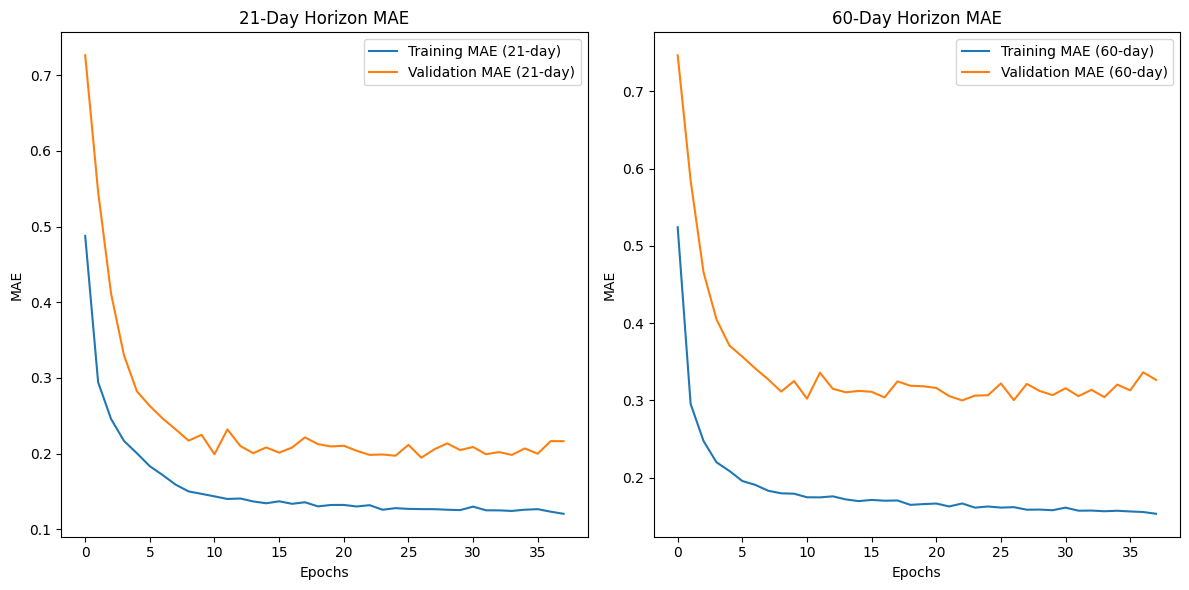

In [201]:
# Initialize random seeds for reproducibility
set_random_seeds()

def train_bilstm_model_ht(model, X, y_21, y_60, model_name):
    """
    Train a hypertuned BiLSTM model with time series cross-validation, early stopping,
    and save the model.

    Args:
    - model (Model): Compiled BiLSTM model to train.
    - X (np.array): Prepared feature set for BiLSTM.
    - y_21 (np.array): Prepared target set for 21-day horizon.
    - y_60 (np.array): Prepared target set for 60-day horizon.
    - model_name (str): Name used to save the model and checkpoints.

    Returns:
    - model (Model): Trained BiLSTM model.
    - histories (list): List of training history objects for visualization.
    """
    # Set up a checkpoint to save the best model
    checkpoint = ModelCheckpoint(f'best_{model_name}.keras',
                                 monitor='val_loss', save_best_only=True,
                                 verbose=1)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=15, verbose=1,
                                   restore_best_weights=True)
    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,
                                   min_lr=1e-6)
    callbacks = [checkpoint, early_stopping, lr_reducer]

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    all_histories = []

    for train_index, val_index in tscv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train_21, y_val_21 = y_21[train_index], y_21[val_index]
        y_train_60, y_val_60 = y_60[train_index], y_60[val_index]

        # Train the model on both 21-day and 60-day predictions
        history = model.fit(X_train, [y_train_21, y_train_60],
                            epochs=50, batch_size=32,
                            validation_data=(X_val, [y_val_21, y_val_60]),
                            callbacks=[checkpoint, early_stopping])

        all_histories.append(history.history)

    # Save the model using joblib for later use
    joblib.dump(model, f'{model_name}.joblib')

    return model, all_histories

# Train the hypertuned model
model_ht, histories_ht = train_bilstm_model_ht(model_ht, X_train_bilstm, y_train_bilstm_21,
                                               y_train_bilstm_60, 'bilstm_model_ht')

# Plot the training history for the 21-day and 60-day horizons
plt.figure(figsize=(12, 6))

# Get the keys dynamically from the history to avoid key errors
history_keys = list(histories_ht[0].keys())
print("Available keys in history:", history_keys)

# Dynamically identify MAE keys
mae_keys = [key for key in history_keys if 'mean_absolute_error' in key]
print("Identified MAE keys:", mae_keys)

# Separate keys for the 21-day and 60-day horizons
if len(mae_keys) >= 2:
    mae_21_key = mae_keys[0]
    val_mae_21_key = f'val_{mae_21_key}'
    mae_60_key = mae_keys[1]
    val_mae_60_key = f'val_{mae_60_key}'

    # 21-day horizon
    plt.subplot(1, 2, 1)
    plt.plot(histories_ht[0][mae_21_key], label='Training MAE (21-day)')
    plt.plot(histories_ht[0][val_mae_21_key], label='Validation MAE (21-day)')
    plt.title('21-Day Horizon MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # 60-day horizon
    plt.subplot(1, 2, 2)
    plt.plot(histories_ht[0][mae_60_key], label='Training MAE (60-day)')
    plt.plot(histories_ht[0][val_mae_60_key], label='Validation MAE (60-day)')
    plt.title('60-Day Horizon MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.savefig('training_history_ht.png')
    plt.show()
else:
    print("Could not find sufficient MAE keys for plotting. Please check the history keys.")


In [3]:
def evaluate_and_plot_ht_model(model, preprocessed_data, model_name, input_window_size,
                               forecast_horizon_21, forecast_horizon_60, output_dir):
    """
    Evaluate the performance of the hypertuned model on test and extra test sets, save the results,
    and generate visualizations.

    Args:
    - model: The trained hypertuned model to evaluate.
    - preprocessed_data: The preprocessed data dictionary with 'test' and 'extra' sets.
    - model_name: The name of the model (e.g., 'BiLSTM', 'XGBoost', 'SVM').
    - input_window_size: The input window size used for the model.
    - forecast_horizon_21: The forecast horizon for the test set (21-day).
    - forecast_horizon_60: The forecast horizon for the extra test set (60-day).
    - output_dir: The directory to save the results and plots.

    Returns:
    - None. Results are saved to the specified output directory.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialize lists to store evaluation metrics
    results_test = []
    results_extra = []

    # Evaluate on test set (21-day horizon)
    for ticker in preprocessed_data['test'].keys():
        print(f"Evaluating {ticker} for {forecast_horizon_21}-day horizon on test set")

        # Prepare the test data
        X_test, y_test, _ = prepare_data_for_bilstm(
            preprocessed_data['test'][ticker]['X'],
            preprocessed_data['test'][ticker]['y'],
            input_window_size=input_window_size,
            forecast_horizon_21=forecast_horizon_21,
            forecast_horizon_60=0
        )

        # Predict on the test set
        y_pred_test = model.predict(X_test)[0]  # [0] for the first output

        # Load the target scaler
        test_scaler = preprocessed_data['test'][ticker]['target_scaler']

        # Inverse transform the predictions and true values
        y_pred_unscaled = test_scaler.inverse_transform(y_pred_test)
        y_true_unscaled = test_scaler.inverse_transform(y_test)

        # Calculate RMSE, MAE, and R2 for the test set
        rmse_test = np.sqrt(mean_squared_error(y_true_unscaled, y_pred_unscaled))
        mae_test = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
        r2_test = r2_score(y_true_unscaled, y_pred_unscaled)

        # Store the results
        results_test.append({
            'Ticker': ticker,
            'RMSE': rmse_test,
            'MAE': mae_test,
            'R2': r2_test
        })

        # Time step plot for the 21-day horizon
        plt.figure(figsize=(10, 6))
        plt.plot(y_true_unscaled.flatten(), label='Actual')
        plt.plot(y_pred_unscaled.flatten(), label='Predicted')
        plt.title(f'{ticker} - {forecast_horizon_21}-Day Horizon - Actual vs. Predicted')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.savefig(os.path.join(output_dir, f'{ticker}_{forecast_horizon_21}_day_time_step_plot.png'))
        plt.show()

    # Evaluate on extra test set (60-day horizon)
    for ticker in preprocessed_data['extra'].keys():
        print(f"Evaluating {ticker} for {forecast_horizon_60}-day horizon on extra test set")

        # Prepare the extra test data
        X_extra, _, y_extra = prepare_data_for_bilstm(
            preprocessed_data['extra'][ticker]['X'],
            preprocessed_data['extra'][ticker]['y'],
            input_window_size=input_window_size,
            forecast_horizon_21=0,  # Set to 0 because we're only evaluating the 60-day horizon
            forecast_horizon_60=forecast_horizon_60
        )

        # Predict on the extra test set
        y_pred_extra = model.predict(X_extra)[1]  # [1] for the second output

        # Load the target scaler
        extra_scaler = preprocessed_data['extra'][ticker]['target_scaler']

        # Inverse transform the predictions and true values
        y_pred_unscaled = extra_scaler.inverse_transform(y_pred_extra)
        y_true_unscaled = extra_scaler.inverse_transform(y_extra)

        # Calculate RMSE, MAE, and R2 for the extra test set
        rmse_extra = np.sqrt(mean_squared_error(y_true_unscaled, y_pred_unscaled))
        mae_extra = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
        r2_extra = r2_score(y_true_unscaled, y_pred_unscaled)

        # Store the results
        results_extra.append({
            'Ticker': ticker,
            'RMSE': rmse_extra,
            'MAE': mae_extra,
            'R2': r2_extra
        })

        # Time step plot for the 60-day horizon
        plt.figure(figsize=(10, 6))
        plt.plot(y_true_unscaled.flatten(), label='Actual')
        plt.plot(y_pred_unscaled.flatten(), label='Predicted')
        plt.title(f'{ticker} - {forecast_horizon_60}-Day Horizon - Actual vs. Predicted')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.savefig(os.path.join(output_dir, f'{ticker}_{forecast_horizon_60}_day_time_step_plot.png'))
        plt.show()

    # Convert results to DataFrame for easy viewing
    results_test_df = pd.DataFrame(results_test)
    results_extra_df = pd.DataFrame(results_extra)

    # Save the results to CSV files in the defined output directory
    results_test_df.to_csv(os.path.join(output_dir, f'{model_name}_test_set_results.csv'), index=False)
    results_extra_df.to_csv(os.path.join(output_dir, f'{model_name}_extra_test_set_results.csv'), index=False)

    # Plotting the results
    def plot_results(df, title):
        df_sorted = df.sort_values(by='RMSE', ascending=False)

        plt.figure(figsize=(14, 6))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.bar(df_sorted['Ticker'], df_sorted['RMSE'], color='orange')
        plt.title(f'RMSE - {title}')
        plt.ylabel('RMSE')
        plt.xticks(rotation=45, ha='right')

        # Plot MAE
        plt.subplot(1, 2, 2)
        plt.bar(df_sorted['Ticker'], df_sorted['MAE'], color='blue')
        plt.title(f'MAE - {title}')
        plt.ylabel('MAE')
        plt.xticks(rotation=45, ha='right')

        plt.suptitle(f'Evaluation Metrics - {model_name}')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(os.path.join(output_dir, f'{title}_evaluation_plot.png'))
        plt.show()

    # Plot for test set
    plot_results(results_test_df, f'Test Set ({forecast_horizon_21}-day Horizon)')

    # Plot for extra test set
    plot_results(results_extra_df, f'Extra Test Set ({forecast_horizon_60}-day Horizon)')

# Call the function to evaluate the hypertuned model
model_ht = joblib.load('bilstm_model_ht.joblib')
evaluate_and_plot_ht_model(
    model=model_ht,
    preprocessed_data=preprocessed_data,
    model_name='BiLSTM_HT',
    input_window_size=10,
    forecast_horizon_21=21,
    forecast_horizon_60=60,
    output_dir='/mnt/data/evaluation_results_ht'  # Adjust output directory to separate results
)


NameError: name 'joblib' is not defined

In [ ]:
# Set random seeds for reproducibility
set_random_seeds


# Load the evaluation results
results_test_df = pd.read_csv('/mnt/data/evaluation_results/BiLSTM_test_set_results.csv')
results_extra_df = pd.read_csv('/mnt/data/evaluation_results/BiLSTM_extra_test_set_results.csv')

# Define a function to plot the results
def plot_evaluation_metrics(df, title, metric='RMSE'):
    df_sorted = df.sort_values(by=metric, ascending=False)

    plt.figure(figsize=(14, 6))

    # Plot the selected metric
    plt.bar(df_sorted['Ticker'], df_sorted[metric], color='skyblue')
    plt.title(f'{metric} - {title}')
    plt.ylabel(metric)
    plt.xlabel('Ticker')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot RMSE and MAE for the 21-day horizon
plot_evaluation_metrics(results_test_df, 'Test Set (21-day Horizon)', metric='RMSE')
plot_evaluation_metrics(results_test_df, 'Test Set (21-day Horizon)', metric='MAE')

# Plot RMSE and MAE for the 60-day horizon
plot_evaluation_metrics(results_extra_df, 'Extra Test Set (60-day Horizon)', metric='RMSE')
plot_evaluation_metrics(results_extra_df, 'Extra Test Set (60-day Horizon)', metric='MAE')


In [ ]:
from google.colab import userdata
userdata.get('secretName')

In [ ]:
from google.colab import userdata
userdata.get('secretName')

In [65]:
def build_svm_model(input_shape, forecast_horizon):
    """
    Build an SVM model for multi-horizon forecasting.

    Args:
    - input_shape (tuple): Shape of the input data (timesteps, features).
    - forecast_horizon (int): Number of future time steps to predict.

    Returns:
    - tuple: (svm model, scaler)
    """
    scaler = StandardScaler()
    svm = SVR(kernel='rbf', C=1000, gamma='scale')
    return svm, scaler

def build_xgboost_model(input_shape, forecast_horizon):
    """
    Build an XGBoost model for multi-horizon forecasting.

    Args:
    - input_shape (tuple): Shape of the input data (timesteps, features).
    - forecast_horizon (int): Number of future time steps to predict.

    Returns:
    - XGBRegressor: Compiled XGBoost model.
    """
    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    return xgb


In [164]:
def evaluate_model(y_true, y_pred):
    """
    Evaluate model performance using multiple metrics.

    Args:
    - y_true (array-like): True values.
    - y_pred (array-like): Predicted values.

    Returns:
    - tuple: (MAE, RMSE, R²)
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 5, 7)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_12          │ (None, 5, 128)         │         36,864 │ input_layer_6[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 5, 128)         │              0 │ bidirectional_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_13          │ (None, 5, 128)         │         98,816 │ dropout_18[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 5, 128)         │              0 │ bidirectional_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_6 (Attention)   │ (None, 5, 128)         │              0 │ dropout_19[0][0],      │
│                           │                        │                │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 5, 256)         │              0 │ dropout_19[0][0],      │
│ (Concatenate)             │                        │                │ attention_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 5, 32)          │          8,224 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 5, 32)          │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 32)             │              0 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 21)             │            693 │ get_item_6[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 144,597 (564.83 KB)

 Trainable params: 144,597 (564.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5147
Epoch 1: val_loss improved from inf to 0.18817, saving model to best_bilstm_model_21.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.5126 - val_loss: 0.1882
Epoch 2/50
58/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1532
Epoch 2: val_loss improved from 0.18817 to 0.12322, saving model to best_bilstm_model_21.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1513 - val_loss: 0.1232
Epoch 3/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1079
Epoch 3: val_loss improved from 0.12322 to 0.11671, saving model to best_bilstm_model_21.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1078 - val_loss: 0.1167
Epoch 4/50
61/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0884
Epoch 4: val_loss did not improve from 0.11671
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0884 - val_loss: 0.1187
Epoch 5/50
57/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0734
Epoch 5: val_loss improved from 0.11671 to 0.11631, 

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 5, 7)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_14          │ (None, 5, 128)         │         36,864 │ input_layer_7[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 5, 128)         │              0 │ bidirectional_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_15          │ (None, 5, 128)         │         98,816 │ dropout_21[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 5, 128)         │              0 │ bidirectional_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_7 (Attention)   │ (None, 5, 128)         │              0 │ dropout_22[0][0],      │
│                           │                        │                │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 5, 256)         │              0 │ dropout_22[0][0],      │
│ (Concatenate)             │                        │                │ attention_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 5, 32)          │          8,224 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 5, 32)          │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_7 (GetItem)      │ (None, 32)             │              0 │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 60)             │          1,980 │ get_item_7[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 145,884 (569.86 KB)

 Trainable params: 145,884 (569.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - loss: 1.0134
Epoch 1: val_loss improved from inf to 1.06111, saving model to best_bilstm_model_60.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 1.0183 - val_loss: 1.0611
Epoch 2/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9742
Epoch 2: val_loss did not improve from 1.06111
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9856 - val_loss: 1.0658
Epoch 3/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9446
Epoch 3: val_loss did not improve from 1.06111
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9605 - val_loss: 1.0645
Epoch 4/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9090
Epoch 4: val_loss improved from 1.06111 to 1.05993, saving model to best_bilstm_model_60.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9283 - val_loss: 1.0599
Epoch 5/50
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8911
Epoch 5: val_loss improved from 1.05993 to 1.05416, saving model to best_bilstm_model_60.keras
6/6 ━━━━━━━━━━━━━

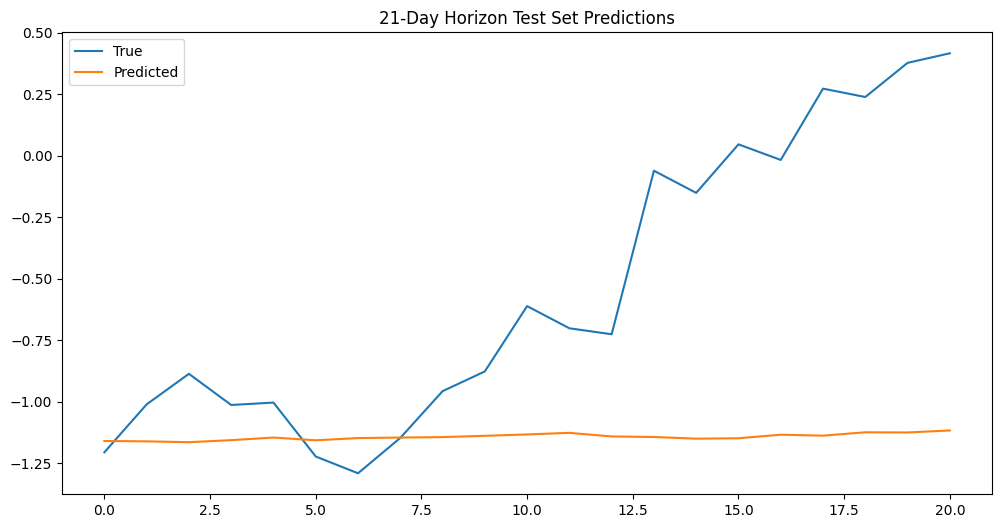

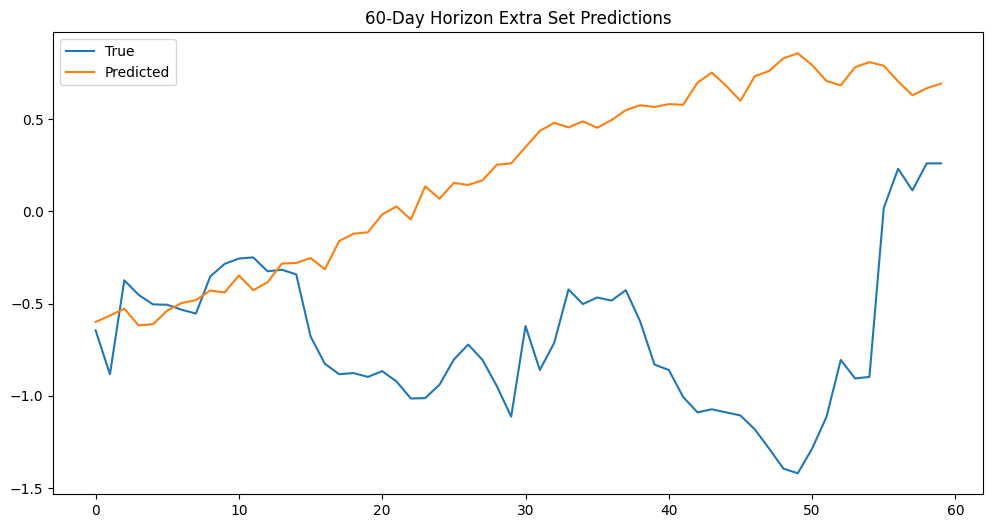

In [63]:
# Initialize random seeds for reproducibility
set_random_seeds()

def train_bilstm_model(X, y, input_shape, forecast_horizon, model_name):
    """
    Train a BiLSTM model with time series cross-validation, early stopping,
     and save the model.

    Args:
    - X (np.array): Prepared feature set for BiLSTM.
    - y (np.array): Prepared target set for BiLSTM.
    - input_shape (tuple): Shape of the input data (timesteps, features).
    - forecast_horizon (int): Number of future time steps to predict.
    - model_name (str): Name used to save the model and checkpoints.

    Returns:
    - model (Model): Trained BiLSTM model.
    """
    # Initialize the BiLSTM model
    model = build_bilstm_attention_model(input_shape, forecast_horizon)

    # Model architecture and summary
    plot_model(model, to_file=f'{model_name}_architecture.png', show_shapes=True)
    model.summary()

    # Set up a checkpoint to save the best model
    checkpoint = ModelCheckpoint(f'best_{model_name}.keras',
                                 monitor='val_loss', save_best_only=True,
                                 verbose=1)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=10, verbose=1,
                                   restore_best_weights=True)

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32,
                  validation_data=(X_val, y_val),
                  callbacks=[checkpoint, early_stopping])

    # Save the model using joblib for later use
    joblib.dump(model, f'{model_name}.joblib')

    return model

# Training the model for the 21-day forecast horizon
model_21 = train_bilstm_model(X_train_bilstm, y_train_bilstm,
                              input_shape, forecast_horizon_21,
                              'bilstm_model_21')

# Training the model for the 60-day forecast horizon
model_60 = train_bilstm_model(X_extra_bilstm, y_extra_bilstm, input_shape,
                              forecast_horizon_60, 'bilstm_model_60')

# Visualizing predictions for the first entry in the test set
test_predictions_21 = model_21.predict(X_test_bilstm)
extra_predictions_60 = model_60.predict(X_extra_bilstm)

# Visualization for 21-day predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm[0], label='True')
plt.plot(test_predictions_21[0], label='Predicted')
plt.title('21-Day Horizon Test Set Predictions')
plt.legend()
plt.show()

# Visualization for 60-day predictions
plt.figure(figsize=(12, 6))
plt.plot(y_extra_bilstm[0], label='True')
plt.plot(extra_predictions_60[0], label='Predicted')
plt.title('60-Day Horizon Extra Set Predictions')
plt.legend()
plt.show()

X_train_combined shape: (12370, 21, 7)
y_train_combined shape: (12370, 5)


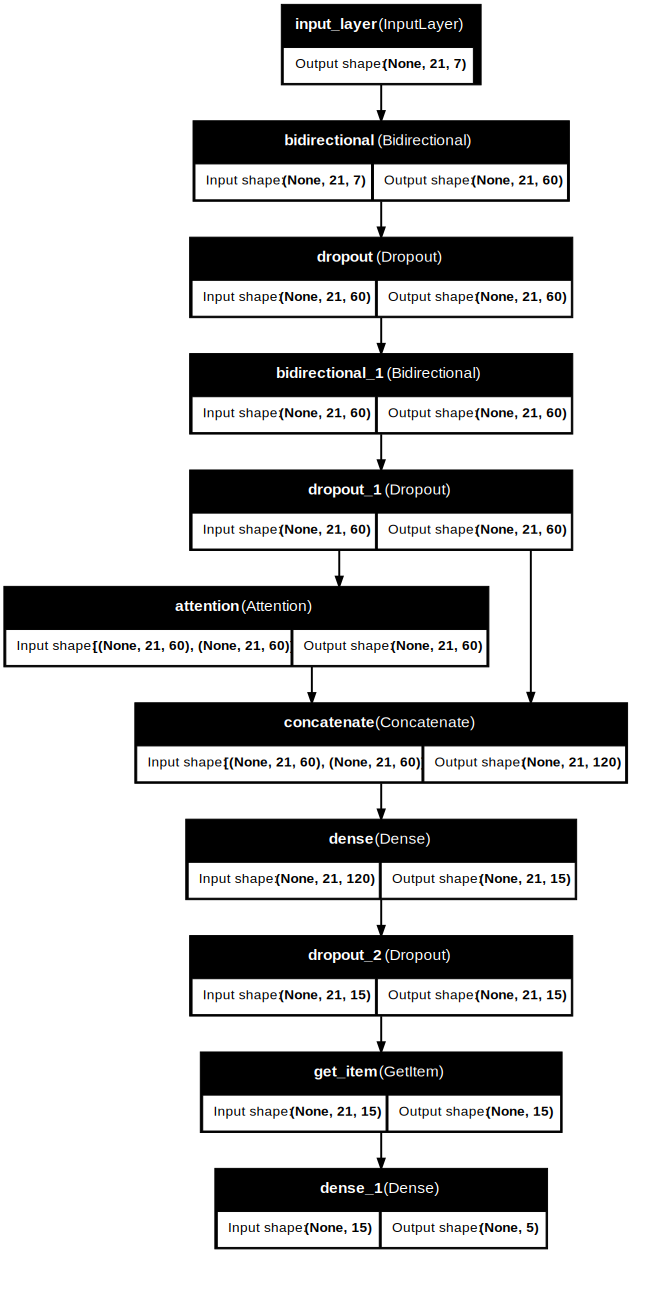

Model architecture saved as 'bilstm_attention_model.png'.


In [ ]:
# Initialize random seeds for reproducibility
set_random_seeds()

def prepare_data_for_lstm(X, y, input_window_size=21, forecast_horizon=5):
    """
    Prepare rolling windows of features and targets for LSTM with
     multi-horizon predictions.

    Args:
    X (array-like): Feature data.
    y (array-like): Target data.
    input_window_size (int): Size of the input rolling window.
    forecast_horizon (int): Number of future time steps to predict.

    Returns:
    tuple: Arrays of rolling window features and multi-horizon targets.
    """
    X_windows, y_windows = [], []
    for i in range(len(X) - input_window_size - forecast_horizon + 1):
        X_windows.append(X[i:i + input_window_size])
        y_windows.append(
            y[i + input_window_size:i + input_window_size + forecast_horizon])
    return np.array(X_windows), np.array(y_windows)


input_window_size = 21
forecast_horizon = 5
X_train_combined, y_train_combined = [], []
tickers = ['SVT', 'CCH', 'BATS', 'GLEN', 'LGEN']

# Loop through each ticker and prepare LSTM data
for ticker in tickers:
    X = preprocessed_data['train'][ticker]['X'].values
    y = preprocessed_data['train'][ticker]['y'].values
    X_windows, y_windows = prepare_data_for_lstm(X, y,
                                                 input_window_size,
                                                 forecast_horizon)
    X_train_combined.append(X_windows)
    y_train_combined.append(y_windows)

# Combine data from all tickers
X_train_combined = np.concatenate(X_train_combined, axis=0)
y_train_combined = np.concatenate(y_train_combined, axis=0)

print("X_train_combined shape:", X_train_combined.shape)
print("y_train_combined shape:", y_train_combined.shape)


def build_bilstm_with_attention(input_shape, forecast_horizon=5):
    """
    Build a BiLSTM model with an attention mechanism for multi-horizon predictions.

    Args:
    input_shape (tuple): Shape of the input data (timesteps, features).
    forecast_horizon (int): Number of future time steps to predict.

    Returns:
    Model: Compiled Keras model.
    """
    inputs = Input(shape=input_shape)

    # First BiLSTM layer
    x = Bidirectional(LSTM(30, return_sequences=True,
                           kernel_regularizer=l2(0.01)))(inputs)
    x = Dropout(0.3)(x)

    # Second BiLSTM layer
    x = Bidirectional(LSTM(30, return_sequences=True,
                           kernel_regularizer=l2(0.01)))(x)
    x = Dropout(0.3)(x)

    # Attention mechanism
    attention = Attention()([x, x])
    x = Concatenate()([x, attention])

    # Dense layers
    x = Dense(15, activation='relu',
              kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)

    # Output layer predicting multiple time steps
    output = Dense(forecast_horizon)(x[:, -1, :])

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse', metrics=['mae'])
    return model

# Define input shape and build the model
input_shape = (X_train_combined.shape[1], X_train_combined.shape[2])
forecast_horizon = 5
model = build_bilstm_with_attention(input_shape, forecast_horizon)

# Visualize model architecture
dot = model_to_dot(model, show_shapes=True, dpi=70)
svg_string = dot.create(prog='dot', format='svg')
display(SVG(svg_string))

# Save model architecture as an image
plot_model(model, to_file='bilstm_attention_model.png',
           show_shapes=True)

print("Model architecture saved as 'bilstm_attention_model.png'.")


# LSTM Model Train

In this phase of my project, I employ a rigorous training strategy for the BiLSTM model with an attention mechanism. This strategy involves using TimeSeriesSplit cross-validation, a technique that enhances the robustness of the model by ensuring that it is trained and validated across different temporal subsets of the data. Below is an explanation of the steps and rationale behind the training process.

#### **Setting Random Seeds for Reproducibility**

Before training the model, I set random seeds using the `set_random_seeds()` function. This step is crucial for ensuring that the training process is consistent across different runs. By setting random seeds, I make sure that factors like data shuffling, model weight initialization, and batch processing produce the same results each time. This consistency is essential for comparing model performance fairly and for reproducibility of the results.

TimeSeriesSplit is a technique specifically designed for time series data. It splits the dataset into several folds while preserving the chronological order, ensuring that the model is trained on past data and validated on future data. This method avoids the risk of data leakage, where future data could incorrectly influence the model during training.

 By training and validating the model on different temporal subsets of the data, TimeSeriesSplit helps ensure that the model generalizes well to unseen future data, rather than just fitting the specific data it was trained on.
  
  TimeSeriesSplit maintains the chronological order of the data, which is crucial in time series forecasting. This method prevents data from future dates from being used to predict past dates, which would lead to unrealistic and misleading results.

**Training Process:**

- **Model Initialization:** For each split, the model is re-initialized by calling `build_bilstm_with_attention`. This ensures that each split starts with a fresh model, preventing any carryover of learned weights from previous splits.

- **Early Stopping and Learning Rate Scheduler:**
  - **Early Stopping:** This technique monitors the validation loss and stops training if the model's performance stops improving, preventing overfitting.

  - **Learning Rate Scheduler:** The learning rate is reduced if the validation loss does not improve for a certain number of epochs, helping the model converge more effectively.

- **TensorBoard Logging:** TensorBoard is used to log training progress, including loss metrics and model architecture. This logging helps in monitoring the model’s performance during training and provides insights into how the model is learning over time.

- **Loss History Tracking:** For each split, I track the training and validation loss. This tracking allows me to visualize how well the model is learning and generalizing across different temporal splits. I used MSE as the loss function becaue it penalises larger errors more as a result of its quatratic nature and a standard metrc for regression problem. In addition , I also monitor the Mean Absolute Erroe (MAE) to get an interpretable measure of the average prediction error .

#### **Model Summary and Visualization**

During the first split, I print a summary of the model’s architecture, which provides details about the layers, the number of parameters, and the model’s structure. I also save the model architecture as an image, which serves as a reference for understanding the model's design.

#### **Final Model Saving and Loss Plotting**

After completing the training across all splits, I save the final model. This final model is the one that has been trained with the benefit of TimeSeriesSplit, making it more robust and reliable for future predictions.

- **Plotting Loss Curves:** I also plot the training and validation loss curves for each split. These curves are crucial for analyzing the model’s performance, showing how well the model is fitting the data during training and how well it generalizes to unseen data during validation.



The use of TimeSeriesSplit cross-validation in training the BiLSTM model with an attention mechanism ensures that the model is thoroughly validated and robust. By carefully managing the training process with early stopping, learning rate scheduling, and TensorBoard logging, I ensure that the model not only fits the training data well but also generalizes effectively to unseen data. This rigorous approach is crucial for developing a reliable model capable of making accurate stock price predictions over multiple time horizons.



Fold 1

Model Summary:


Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_81            │ (None, 21, 7)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_162         │ (None, 21, 60)         │          9,120 │ input_layer_81[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_243 (Dropout)     │ (None, 21, 60)         │              0 │ bidirectional_162[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_163         │ (None, 21, 60)         │         21,840 │ dropout_243[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_244 (Dropout)     │ (None, 21, 60)         │              0 │ bidirectional_163[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_81 (Attention)  │ (None, 21, 60)         │              0 │ dropout_244[0][0],     │
│                           │                        │                │ dropout_244[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_81            │ (None, 21, 120)        │              0 │ dropout_244[0][0],     │
│ (Concatenate)             │                        │                │ attention_81[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_162 (Dense)         │ (None, 21, 15)         │          1,815 │ concatenate_81[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_245 (Dropout)     │ (None, 21, 15)         │              0 │ dense_162[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_81 (GetItem)     │ (None, 15)             │              0 │ dropout_245[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_163 (Dense)         │ (None, 5)              │             80 │ get_item_81[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,855 (128.34 KB)

 Trainable params: 32,855 (128.34 KB)

 Non-trainable params: 0 (0.00 B)

Architecture saved as 'model_architecture.png'
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 2.1762 - mae: 0.4932 - val_loss: 1.1507 - val_mae: 0.4286 - learning_rate: 0.0010
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.8915 - mae: 0.3116 - val_loss: 0.4771 - val_mae: 0.3033 - learning_rate: 0.0010
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.4240 - mae: 0.2704 - val_loss: 0.2604 - val_mae: 0.2827 - learning_rate: 0.0010
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.2426 - mae: 0.2462 - val_loss: 0.1546 - val_mae: 0.2274 - learning_rate: 0.0010
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1763 - mae: 0.2344 - val_loss: 0.1471 - val_mae: 0.2610 - learning_rate: 0.0010
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1481 - mae: 0.2294 - val_loss: 0.1150 - val_mae: 0.2316 - learning_rate: 0.0010
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1214 - mae: 0.2121 - val_loss: 0.0942 - val_ma

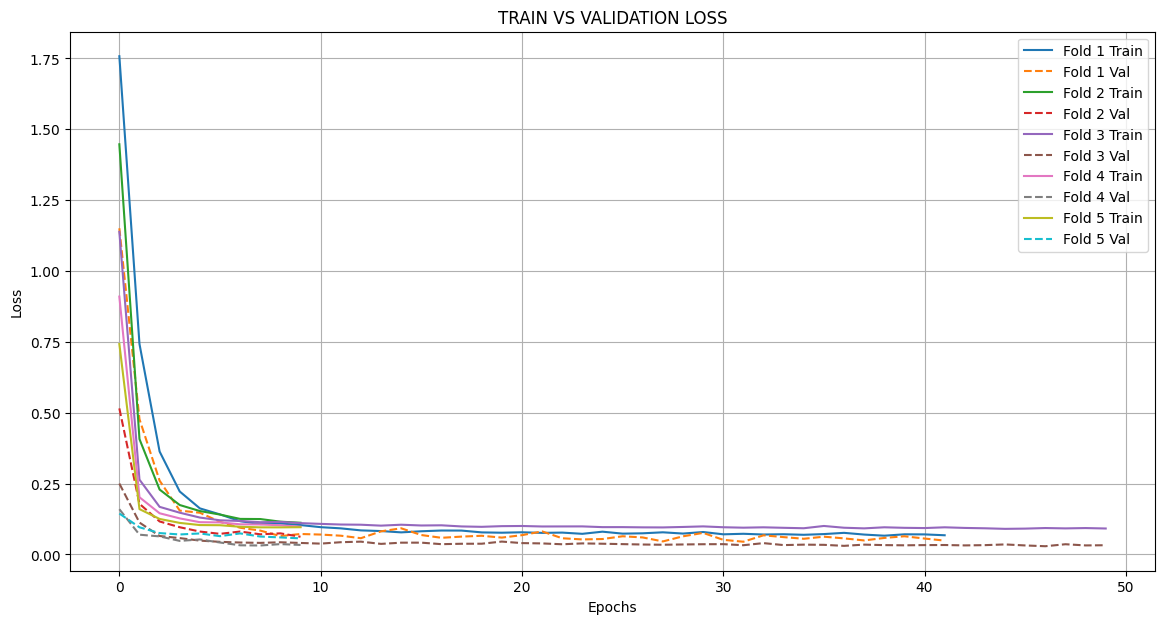

Loss plot saved as 'loss_plot.png'


In [ ]:
# Set random seeds for reproducibility
set_random_seeds()

def train_bilstm_with_kfold(X_train_combined, y_train_combined,
                            build_bilstm_with_attention,
                            epochs=50, batch_size=32, forecast_horizon=5):
    """
    Train a BiLSTM model with TimeSeriesSplit cross-validation and visualize the
     training/validation loss for multi-horizon predictions.

    Args:
    - X_train_combined (np.array): Combined training features.
    - y_train_combined (np.array): Combined training labels.
    - build_bilstm_with_attention (function): Function to build the BiLSTM
     model with attention.
    - epochs (int): Number of epochs to train each fold. Default is 50.
    - batch_size (int): Batch size for training. Default is 32.
    - forecast_horizon (int): Number of future time steps to predict. Default is 5.

    Returns:
    - model (tf.keras.Model): The trained model.
    - train_loss_history (list): Training loss history for each fold.
    - val_loss_history (list): Validation loss history for each fold.
    """

    # Set random seeds for reproducibility
    set_random_seeds()

    # Define model input shape
    input_shape = (X_train_combined.shape[1], X_train_combined.shape[2])

    # Initialize TimeSeriesSplit for time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Define early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10,
                                   restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                     patience=5, min_lr=1e-6)

    # Directory for TensorBoard logs
    log_dir = os.path.join("logs",
                           datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Initialize lists to store loss history
    train_loss_history = []
    val_loss_history = []

    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_combined), 1):
        print(f"\nFold {fold}")

        # Split train and validation data
        X_train, X_val = X_train_combined[train_idx], X_train_combined[val_idx]
        y_train, y_val = y_train_combined[train_idx], y_train_combined[val_idx]

        # Rebuild the model for each fold
        model = build_bilstm_with_attention(input_shape, forecast_horizon)

        # Display model summary only for the first fold
        if fold == 1:
            print("\nModel Summary:")
            model.summary()
            # Save the model architecture as PNG
            plot_model(model, to_file='model_architecture.png',
                       show_shapes=True, show_layer_names=True)
            print("Architecture saved as 'model_architecture.png'")

        # Train with early stopping, learning rate scheduler, and TensorBoard
        history = model.fit(X_train, y_train, epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val, y_val), verbose=1,
                            callbacks=[early_stopping, lr_scheduler,
                                       tensorboard_callback])

        # Store the loss history for each fold
        train_loss_history.append(history.history['loss'])
        val_loss_history.append(history.history['val_loss'])

    print("Training completed.")

    # Save the final model
    model.save('bilstm_attention_model.keras')
    print("Final model saved as 'bilstm_attention_model.keras'")

    # Plot and save the loss curves
    plot_loss(train_loss_history, val_loss_history)

    return model, train_loss_history, val_loss_history

# Call the function
model, train_loss_history, val_loss_history = train_bilstm_with_kfold(
    X_train_combined,
    y_train_combined,
    build_bilstm_with_attention,
    forecast_horizon=5
)

### Evaluation of the BiLSTM Model

In this phase, I evaluate the performance of the trained BiLSTM model with attention on the test and extra datasets. This evaluation is essential for determining how well the model generalizes to unseen data and its ability to make accurate predictions across multiple time horizons.

#### **Reproducibility**

I start by setting random seeds to ensure consistent results across multiple runs, which is crucial for validating the model's reliability.

#### **Data Preparation**

The data from all tickers is combined and prepared for evaluation by creating rolling windows. This approach ensures a comprehensive evaluation that reflects the model’s performance across various stocks.

#### **Inverse Transforming Predictions**

Since the model’s predictions are made on scaled data, I inverse transform them back to the original scale to enable accurate comparison with actual stock prices.

#### **Model Evaluation**

I load the trained BiLSTM model and evaluate it by predicting stock prices for the test and extra datasets. Key performance metrics, including RMSE, MAE, R², MAPE, and Directional Accuracy, are calculated for each prediction horizon (e.g., 1-day ahead, 2-day ahead).

#### **Printing and Saving Metrics**

The evaluation metrics are printed in a clear format and saved in JSON files for future reference. This documentation is important for analyzing and comparing the model’s performance over time.

### Summary

This evaluation process provides a thorough assessment of the BiLSTM model's ability to predict stock prices across multiple horizons, ensuring its effectiveness and generalizability.


In [163]:
# Set random seeds for reproducibility
set_random_seeds()

def prepare_combined_data(data, type, win_size=21, horz=5):
    """
    Prepare data for LSTM input and combine
    data from all tickers.

    Args:
    - data (dict): Preprocessed data.
    - type (str): 'test' or 'extra'.
    - win_size (int): Window size.
    - horz (int): Forecast horizon.

    Returns:
    - X_comb (np.array): Combined features.
    - y_comb (np.array): Combined targets.
    """
    X_comb, y_comb = [], []

    for ticker, d in data[type].items():
        X = d['X'].values
        y = d['y'].values
        X_win, y_win = create_rolling_window_data(
            X, y, win_size, horz)
        X_comb.append(X_win)
        y_comb.append(y_win)

    X_comb = np.concatenate(X_comb, axis=0)
    y_comb = np.concatenate(y_comb, axis=0)

    return X_comb, y_comb

def inv_transform_preds(y, data, type):
    """
    Inverse transform predictions.

    Args:
    - y (np.array): Predicted values.
    - data (dict): Preprocessed data.
    - type (str): 'test' or 'extra'.

    Returns:
    - y_inv (np.array): Inverse transformed predictions.
    """
    y_inv = np.zeros_like(y)
    start = 0
    for ticker, d in data[type].items():
        scaler = d['target_scaler']
        end = start + len(d['y']) - 21 - 5 + 1
        y_inv[start:end] = scaler.inverse_transform(
            y[start:end])
        start = end
    return y_inv

def eval_model(model, X, y, data, type):
    """
    Evaluate model performance.

    Args:
    - model: Trained model.
    - X (np.array): Features.
    - y (np.array): True values.
    - data (dict): Preprocessed data.
    - type (str): 'test' or 'extra'.

    Returns:
    - metrics (dict): Performance metrics.
    """
    y_pred = model.predict(X)
    y_pred_inv = inv_transform_preds(y_pred, data, type)
    y_true_inv = inv_transform_preds(y, data, type)

    metrics = {}
    for i in range(5):
        rmse = np.sqrt(mean_squared_error(
            y_true_inv[:, i], y_pred_inv[:, i]))
        mae = mean_absolute_error(
            y_true_inv[:, i], y_pred_inv[:, i])
        r2 = r2_score(
            y_true_inv[:, i], y_pred_inv[:, i])
        mape = np.mean(np.abs(
            (y_true_inv[:, i] - y_pred_inv[:, i]) / y_true_inv[:, i])) * 100

        dir_true = np.sign(
            y_true_inv[:, i] - y_true_inv[:, i-1] if i > 0 else y_true_inv[:, i])
        dir_pred = np.sign(
            y_pred_inv[:, i] - y_pred_inv[:, i-1] if i > 0 else y_pred_inv[:, i])
        dir_acc = np.mean(dir_true == dir_pred) * 100

        metrics[f'{i+1}_day_ahead'] = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'MAPE': mape,
            'Directional Accuracy': dir_acc
        }

    return metrics, y_pred_inv, y_true_inv

# Load the trained model
model = load_model('bilstm_attention_model.keras')

# Prepare and evaluate test dataset
X_test_comb, y_test_comb = prepare_combined_data(preprocessed_data, 'test')
test_metrics, test_pred, test_true = eval_model(model, X_test_comb,
                                                y_test_comb,
                                                preprocessed_data, 'test')

# Prepare and evaluate extra dataset
X_extra_comb, y_extra_comb = prepare_combined_data(preprocessed_data, 'extra')
extra_metrics, extra_pred, extra_true = eval_model(model, X_extra_comb,
                                                   y_extra_comb,
                                                   preprocessed_data, 'extra')

# Print results
def print_metrics(metrics, name):
    """
    Print evaluation metrics.

    Args:
    - metrics (dict): Performance metrics.
    - name (str): Dataset name.
    """
    print(f"\n{name} Dataset Evaluation:")
    for horizon, m in metrics.items():
        print(f"{horizon}:")
        print(f"  RMSE: {m['RMSE']:.4f}")
        print(f"  MAE: {m['MAE']:.4f}")
        print(f"  R²: {m['R²']:.4f}")
        print(f"  MAPE: {m['MAPE']:.2f}%")
        print(f"  Directional Accuracy: {m['Directional Accuracy']:.2f}%")

print_metrics(test_metrics, "Test")
print_metrics(extra_metrics, "Extra")


def analyze_perf(pred, true, name):
    """
    Perform additional analysis.

    Args:
    - pred (np.array): Predicted values.
    - true (np.array): True values.
    - name (str): Dataset name.
    """
    print(f"\nAdditional Analysis for {name} Dataset:")
    overall_rmse = np.sqrt(mean_squared_error(true.flatten(), pred.flatten()))
    overall_r2 = r2_score(true.flatten(), pred.flatten())
    print(f"Overall RMSE: {overall_rmse:.4f}")
    print(f"Overall R²: {overall_r2:.4f}")

    rmse_by_horizon = [np.sqrt(mean_squared_error(true[:, i],
                                                  pred[:, i])) for i in range(5)]
    print("RMSE by horizon:")
    for i, rmse in enumerate(rmse_by_horizon):
        print(f"  {i+1}-day ahead: {rmse:.4f}")

    errors = pred - true
    extreme_errors = np.abs(errors) > 2 * np.std(errors)
    print(
        f"Percentage of extreme predictions: \
        {np.mean(extreme_errors) * 100:.2f}%")

analyze_perf(test_pred, test_true, "Test")
analyze_perf(extra_pred, extra_true, "Extra")

# Save metrics
with open('bilstm_test_metrics.json', 'w') as f:
    json.dump(test_metrics, f, indent=4)
with open('bilstm_extra_metrics.json', 'w') as f:
    json.dump(extra_metrics, f, indent=4)
print("Metrics saved to JSON files.")


ValueError: File not found: filepath=bilstm_attention_model.keras. Please ensure the file is an accessible `.keras` zip file.

### Visualization of Performance Metrics

In this section, I use visualization techniques to represent the performance metrics of the BiLSTM model across different forecast horizons. Visualizing these metrics helps in interpreting the model's performance more effectively and in identifying any trends or patterns that may not be immediately obvious from the raw numbers. Below is a detailed explanation of the code, including the purpose of each step and how it is implemented.

#### **Setting Random Seeds for Reproducibility**

To begin, I set random seeds to ensure that the visualizations are consistent and reproducible across different runs. This step is crucial to maintain the integrity of the results and ensure that the plots generated from the same data always look the same.

#### **Function: `visualize_metrics`**

This function is designed to visualize key performance metrics for the model across various forecast horizons. It takes in the metrics data, converts it into a format suitable for plotting, and then creates several bar plots to display these metrics.

**Purpose of the Visualization:**

- **Clarity and Accessibility:** Visualizing the metrics in bar plots makes it easier to compare the model’s performance across different horizons at a glance, highlighting areas of strength and weakness.
- **Trend Identification:** By plotting metrics like RMSE, MAE, MAPE, and Directional Accuracy, I can easily spot trends, such as whether errors increase with longer forecast horizons or if the model maintains consistent directional accuracy over time.

**Implementation Details:**

1. **Data Preparation:**
   - The metrics dictionary, which contains performance data for each forecast horizon, is first converted into a Pandas DataFrame. This structured format makes it easier to plot the data using Seaborn.

2. **RMSE Plot:**
   - A bar plot is created to show the Root Mean Squared Error (RMSE) for each forecast horizon. RMSE is a key metric that indicates the magnitude of the prediction error. By visualizing it, I can easily compare how prediction errors change as the forecast horizon extends.

3. **MAE Plot:**
   - Another bar plot is generated to display the Mean Absolute Error (MAE) across different horizons. MAE provides a straightforward measure of the average error in predictions, and the bar plot helps to quickly identify any significant changes in prediction accuracy.

4. **MAPE Plot:**
   - The Mean Absolute Percentage Error (MAPE) is plotted to show the percentage error relative to the actual values. This metric is particularly useful for understanding how errors scale with the magnitude of the data being predicted.

5. **Directional Accuracy Plot:**
   - Finally, the Directional Accuracy is plotted, which indicates how often the model correctly predicts the direction of price movement (up or down). High directional accuracy is especially important in financial forecasting, and this plot helps to assess the model's reliability in this regard.

**Why Bar Plots Are Used:**

- **Ease of Comparison:** Bar plots allow for easy comparison between different categories (in this case, forecast horizons), making it simple to see which horizon performs better or worse in terms of each metric.
- **Visual Clarity:** The distinct bars make it straightforward to interpret the data, especially when comparing metrics like RMSE and MAE across different forecast periods.

#### **Execution**

The `visualize_metrics` function is called twice—once for the test dataset and once for the extra dataset. This ensures that the model's performance is thoroughly evaluated and compared across both datasets.



This visualization process is crucial for interpreting the performance of the BiLSTM model across different forecast horizons. By converting the metrics into visual plots, I can easily compare the model’s accuracy, error magnitude, and directional reliability over time. This approach not only highlights the model's strengths but also helps to identify areas that may require further optimization.


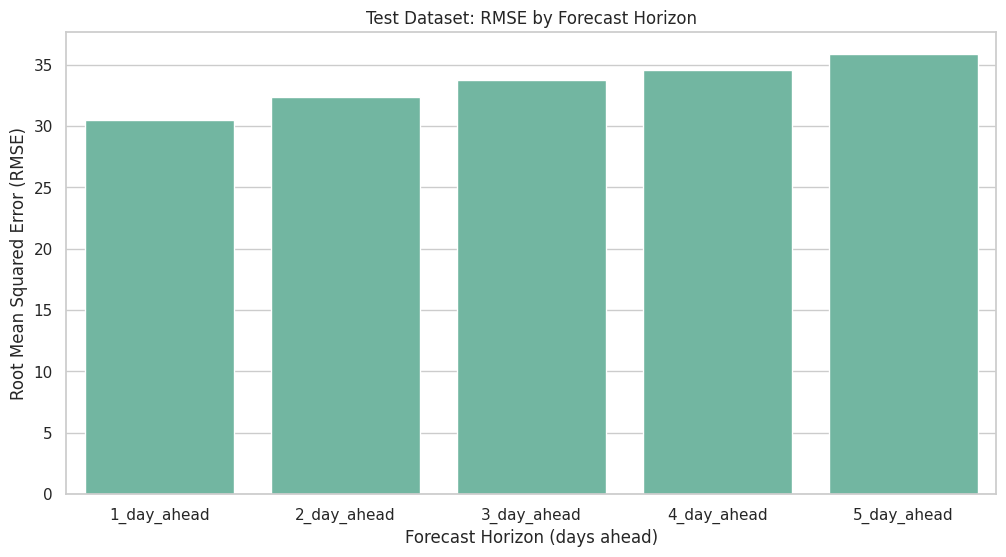

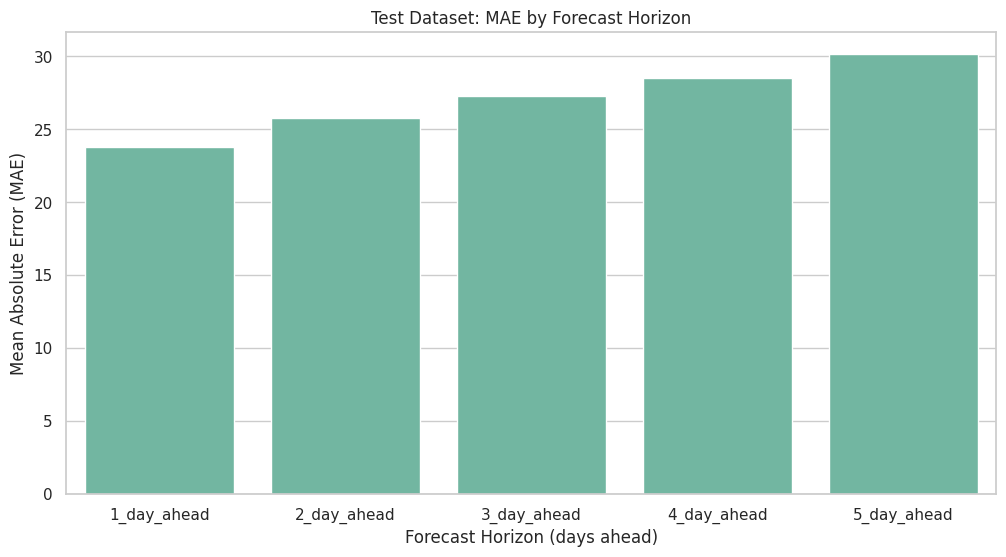

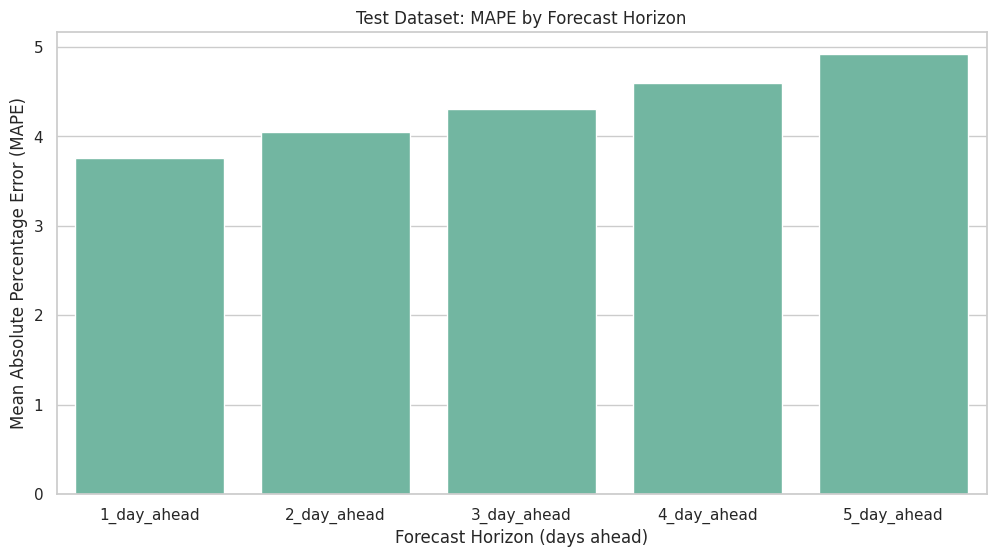

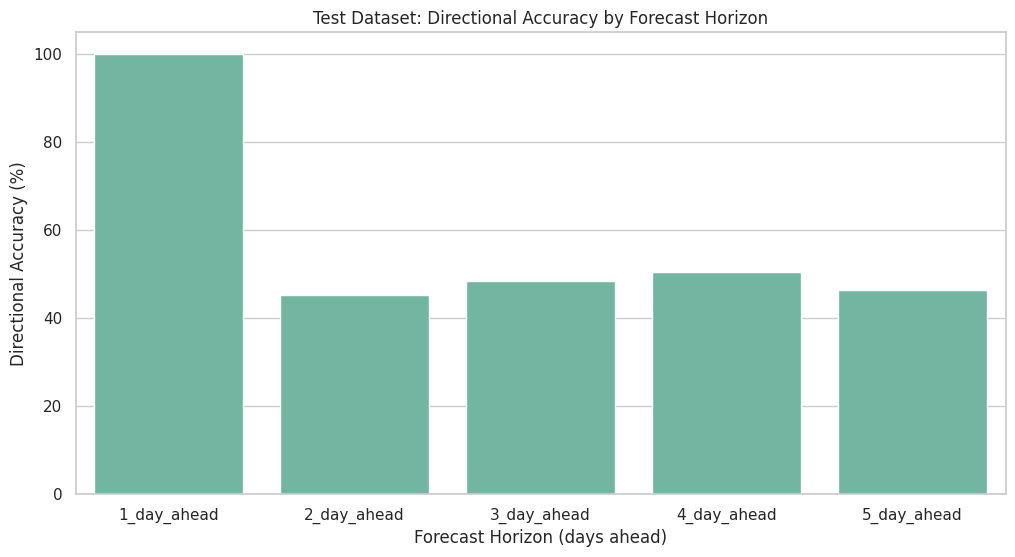

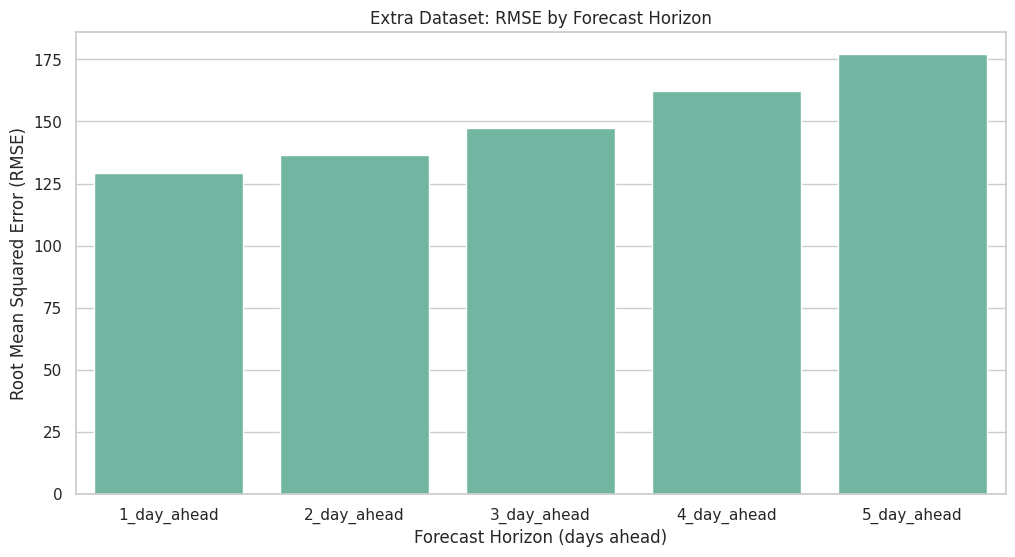

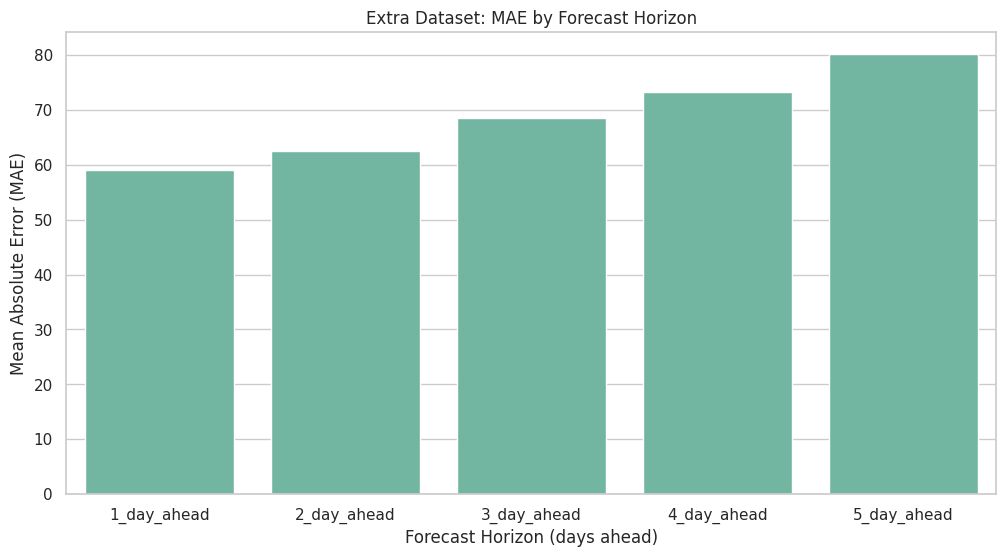

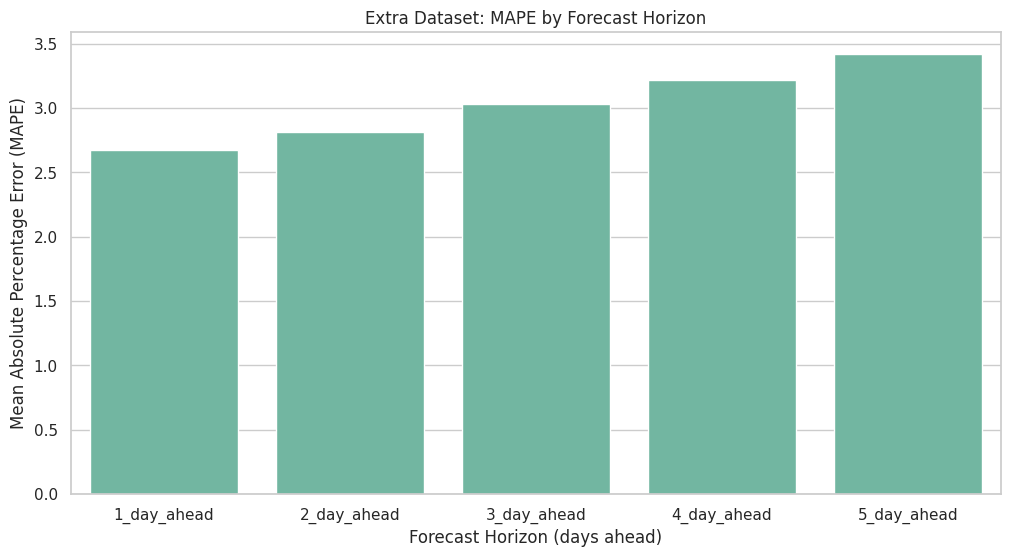

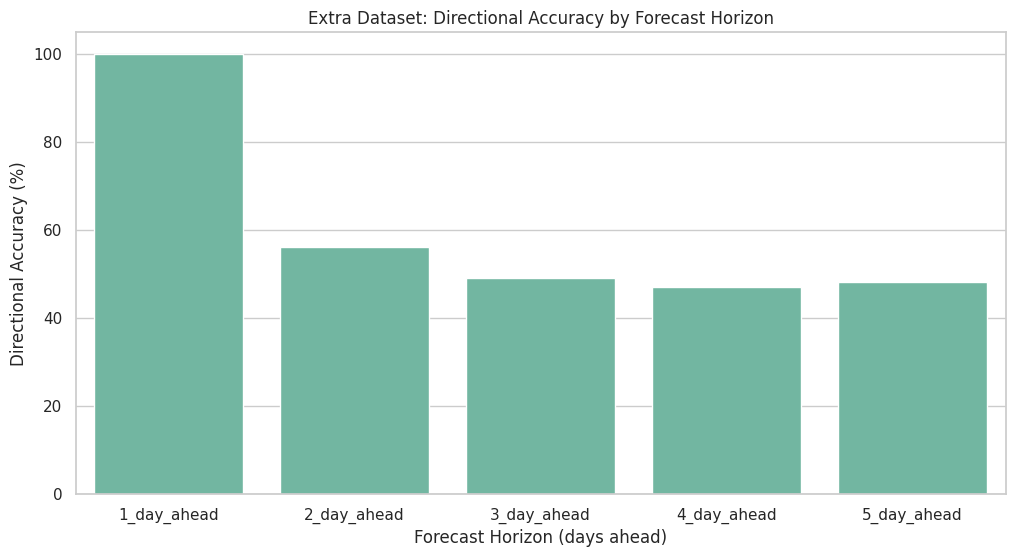

In [ ]:
# Set random seeds for reproducibility
set_random_seeds()

def visualize_metrics(metrics, dataset_name):
    """
    Visualize performance metrics using Seaborn.

    Args:
    - metrics (dict): Performance metrics for different horizons.
    - dataset_name (str): Name of the dataset (e.g., 'Test', 'Extra').
    """
    sns.set(style="whitegrid")
    sns.set_palette("Set2")

    # Convert metrics dictionary to a DataFrame for easier plotting
    metrics_df = pd.DataFrame(metrics).T
    metrics_df.index.name = 'Forecast Horizon'
    metrics_df.reset_index(inplace=True)

    # RMSE Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Forecast Horizon', y='RMSE', data=metrics_df)
    plt.title(f'{dataset_name} Dataset: RMSE by Forecast Horizon')
    plt.xlabel('Forecast Horizon (days ahead)')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.show()

    # MAE Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Forecast Horizon', y='MAE', data=metrics_df)
    plt.title(f'{dataset_name} Dataset: MAE by Forecast Horizon')
    plt.xlabel('Forecast Horizon (days ahead)')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.show()

    # MAPE Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Forecast Horizon', y='MAPE', data=metrics_df)
    plt.title(f'{dataset_name} Dataset: MAPE by Forecast Horizon')
    plt.xlabel('Forecast Horizon (days ahead)')
    plt.ylabel('Mean Absolute Percentage Error (MAPE)')
    plt.show()

    # Directional Accuracy Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Forecast Horizon', y='Directional Accuracy', data=metrics_df)
    plt.title(f'{dataset_name} Dataset: Directional Accuracy by Forecast Horizon')
    plt.xlabel('Forecast Horizon (days ahead)')
    plt.ylabel('Directional Accuracy (%)')
    plt.show()

# Call the function to visualize results for Test and Extra datasets
visualize_metrics(test_metrics, "Test")
visualize_metrics(extra_metrics, "Extra")


# XGBOOST Data Preparation and Model Build

### Explanation of Preparing Data and Building the XGBoost Model

In this section, I prepare the data for training an XGBoost model and then build the model itself. The goal is to train an XGBoost model that can effectively predict future stock prices based on historical data. Below, I explain the steps, their purposes, and how the code implements them.

#### **Setting Random Seeds for Reproducibility**

I start by setting random seeds to ensure that the data preparation and model training process is consistent across different runs. This step is crucial for achieving reproducible results, which is important for validating the model's performance and ensuring that any improvements are due to changes in the model or data rather than random chance.

#### **Preparing Data for XGBoost**

The data preparation process is tailored specifically for training the XGBoost model. The goal here is to convert the time series data into a format that XGBoost can work with effectively.

**Rolling Window Preparation:**

- The `prepare_data_for_xgboost` function creates rolling windows of the feature data (`X`) and the target data (`y`). This involves generating overlapping segments of the time series data that the model can use

 Rolling windows allow the model to learn from sequences of data, which is crucial for capturing temporal dependencies in time series data. Each window provides a snapshot of the past, which the model uses to predict future values.

**Flattening the Data:**

- After creating the rolling windows, the data is flattened so that it can be fed into the XGBoost model. XGBoost expects input data in a flat, tabular format, so this step reshapes the data from a time series format into one that is suitable for the model.

 XGBoost requires input features to be in a two-dimensional array where each row represents a different training example, and each column represents a feature. Flattening the data ensures that the model receives the data in the correct format.

**Combining Data from Multiple Tickers:**

- The `prepare_combined_data_xgboost` function combines data from multiple stock tickers into a single dataset. This is important because training the model on data from multiple stocks can improve its generalization ability and make it more robust to different market conditions.

 Combining data from various tickers helps the model learn from a diverse set of examples, making it more capable of handling different types of stock price movements.

#### **Building the XGBoost Model**

The `build_xgboost_model` function is used to construct the XGBoost model.

- **Model Configuration:**
  - The model is configured to use the squared error as its objective function, which is suitable for regression tasks like predicting stock prices. The number of boosting rounds (`n_estimators`) and the learning rate are also specified.

 XGBoost is a powerful gradient boosting framework that is well-suited for regression tasks. It efficiently handles large datasets and complex relationships in the data, making it an ideal choice for stock price prediction.

#### **Training and Validation Data Split**

Before training the model, the data is split into training and validation sets.

 Splitting the data allows for evaluating the model’s performance on unseen data, which is crucial for assessing its generalization ability.

#### **Model Parameters**

Finally, the model parameters are printed out, giving an overview of the configuration used for training.

### Summary

This section prepares the data and builds an XGBoost model tailored to predict future stock prices. By using rolling windows, flattening the data, and combining data from multiple tickers, I ensure that the model is well-prepared to capture the temporal dependencies and trends in the stock market. The XGBoost model is then built and configured to effectively handle the regression task of predicting stock prices.


In [ ]:
# Set random seed for reproducibility
set_random_seeds()


def prepare_data_for_xgboost(X, y, window=21, horizon=5):
    """
    Prepare data specifically for XGBoost models.

    Args:
    - X (array-like): Feature data.
    - y (array-like): Target data.
    - window (int): Size of the input rolling window.
    - horizon (int): Number of future time steps to predict.

    Returns:
    - X_xgboost (np.array): Flattened features for XGBoost.
    - y_xgboost (np.array): Targets for XGBoost.
    """
    X_windows, y_windows = [], []

    # Create rolling windows of features and targets
    for i in range(len(X) - window - horizon + 1):
        X_windows.append(X[i:i + window])
        y_windows.append(y[i + window:i + window + horizon])

    # Flatten the feature windows to prepare for XGBoost
    X_xgboost = np.array(X_windows).reshape((len(X_windows), -1))
    y_xgboost = np.array(y_windows)

    return X_xgboost, y_xgboost

def prepare_combined_data_xgboost(data, tickers, window=21, horizon=5):
    """
    Prepare and combine data from all tickers for XGBoost.

    Args:
    - data (dict): Preprocessed data for each ticker.
    - tickers (list): List of ticker symbols.
    - window (int): Size of the input rolling window.
    - horizon (int): Number of future time steps to predict.

    Returns:
    - X_train_xgboost (np.array): Combined training features for XGBoost.
    - y_train_xgboost (np.array): Combined training labels for XGBoost.
    """
    X_combined, y_combined = [], []

    for ticker in tickers:
        X = data['train'][ticker]['X'].values
        y = data['train'][ticker]['y'].values
        X_xgboost, y_xgboost = prepare_data_for_xgboost(X, y, window, horizon)
        X_combined.append(X_xgboost)
        y_combined.append(y_xgboost)

    # Combine data from all tickers
    X_combined = np.concatenate(X_combined, axis=0)
    y_combined = np.concatenate(y_combined, axis=0)

    return X_combined, y_combined


def build_xgboost_model():
    """
    Build and return an XGBoost model.

    Returns:
    - xgb_model (XGBRegressor): XGBoost model.
    """
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',  # Use squared error for regression
        n_estimators=100,              # Number of boosting rounds
        learning_rate=0.1              # Learning rate for the model
    )
    return xgb_model


# Define data and model parameters
set_random_seeds()
input_window_size = 21
forecast_horizon = 5
tickers = ['SVT', 'CCH', 'BATS', 'GLEN', 'LGEN']  # Example tickers

# Prepare data for XGBoost
X_train_combined_xgboost, y_train_combined_xgboost = prepare_combined_data_xgboost(
    preprocessed_data, tickers, input_window_size, forecast_horizon
)

# Split data for training and validation
X_train_xgboost, X_val_xgboost, y_train_xgboost,\
 y_val_xgboost = train_test_split(
    X_train_combined_xgboost, y_train_combined_xgboost, test_size=0.2,
    random_state=42
)

# Build the XGBoost model
xgb_model = build_xgboost_model()

# Print model parameters
print("XGBoost Model Parameters:")
print(xgb_model.get_params())


XGBoost Model Parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


## XGBoost Model Train


In this section, I focus on training the XGBoost model using the prepared training and validation data. The goal is to fit the model to the data so it can accurately predict future stock prices. Below is a detailed explanation of what the code does, why it is important, and how it is implemented.

#### **Setting Random Seeds for Reproducibility**

As with the previous steps, I start by setting random seeds to ensure that the training process is consistent and reproducible. This is crucial for validating the model's performance across different runs.

#### **Training the XGBoost Model**

The core of this section is the `train_xgboost_model` function, which is responsible for training the XGBoost model on the provided training data and evaluating its performance on validation data.

**Training Process:**

- **Input Arguments:**
  - `X_train_xgboost` and `y_train_xgboost`: These are the features and labels for the training set. The model learns from this data to predict future stock prices.
  - `X_val_xgboost` and `y_val_xgboost`: These are the features and labels for the validation set. The model's performance is evaluated on this data after each training round to monitor overfitting.
  - `xgb_model`: This is the XGBoost model that has been previously configured.

 The training process involves fitting the model to the training data by adjusting its internal parameters to minimize the prediction error. This is done through multiple iterations, or boosting rounds, where the model gradually improves its predictions.

During training, the model's performance is continually evaluated on the validation set. This helps in tracking the model's ability to generalize to unseen data and prevents overfitting—where the model performs well on training data but poorly on new data.

 The `fit` method is used to train the model on the training data. The `eval_set` parameter is used to specify the validation data, allowing the model to be evaluated on unseen data during training.
- **Verbose Output:** The `verbose=True` option provides detailed output during training, including the loss at each boosting round. This is useful for monitoring the training process and ensuring that the model is learning effectively.

#### **Saving the Trained Model**

Once the model has been trained, it is saved to a file (`trained_xgboost_model.json`) for future use.

 Saving the model allows it to be easily loaded and used later without retraining, saving time and computational resources.

 By saving the trained model, I ensure that the exact same model can be used for predictions, further evaluations, or deployment.


- The `save_model` method is used to save the trained model in JSON format. This format is portable and can be easily loaded back into memory for future predictions.



This section is dedicated to training the XGBoost model on the prepared data and saving the trained model for future use. By carefully monitoring the training process and evaluating the model on validation data, I ensure that the model is both accurate and capable of generalizing to new data. Saving the trained model allows for its reusability, ensuring that the model's performance can be consistently replicated in future tasks.


In [ ]:
# Set random seed for reproducibility
set_random_seeds()

def train_xgboost_model(X_train_xgboost, y_train_xgboost, X_val_xgboost,
                        y_val_xgboost, xgb_model):
    """
    Train the XGBoost model.

    Args:
    - X_train_xgboost (np.array): Training features.
    - y_train_xgboost (np.array): Training labels.
    - X_val_xgboost (np.array): Validation features.
    - y_val_xgboost (np.array): Validation labels.
    - xgb_model (XGBRegressor): XGBoost model.

    Returns:
    - trained_xgb_model (XGBRegressor): Trained XGBoost model.
    """
    print("Training XGBoost model...")
    xgb_model.fit(X_train_xgboost, y_train_xgboost[:, 0],
                  eval_set=[(X_val_xgboost, y_val_xgboost[:, 0])],
                  verbose=True)
    return xgb_model

# Train Models
xgb_model = train_xgboost_model(X_train_xgboost, y_train_xgboost,
                                X_val_xgboost, y_val_xgboost, xgb_model)

# Save the trained model
xgb_model.save_model('trained_xgboost_model.json')
print("Model saved as 'trained_xgboost_model.json'.")

Training XGBoost model...
[0]	validation_0-rmse:0.90027
[1]	validation_0-rmse:0.81220
[2]	validation_0-rmse:0.73295
[3]	validation_0-rmse:0.66145
[4]	validation_0-rmse:0.59709
[5]	validation_0-rmse:0.53944
[6]	validation_0-rmse:0.48758
[7]	validation_0-rmse:0.44124
[8]	validation_0-rmse:0.39974
[9]	validation_0-rmse:0.36246
[10]	validation_0-rmse:0.32938
[11]	validation_0-rmse:0.29962
[12]	validation_0-rmse:0.27314
[13]	validation_0-rmse:0.24958
[14]	validation_0-rmse:0.22851
[15]	validation_0-rmse:0.21000
[16]	validation_0-rmse:0.19356
[17]	validation_0-rmse:0.17908
[18]	validation_0-rmse:0.16624
[19]	validation_0-rmse:0.15493
[20]	validation_0-rmse:0.14522
[21]	validation_0-rmse:0.13676
[22]	validation_0-rmse:0.12937
[23]	validation_0-rmse:0.12295
[24]	validation_0-rmse:0.11740
[25]	validation_0-rmse:0.11274
[26]	validation_0-rmse:0.10870
[27]	validation_0-rmse:0.10522
[28]	validation_0-rmse:0.10230
[29]	validation_0-rmse:0.09982
[30]	validation_0-rmse:0.09777
[31]	validation_0-rmse:

#XGBOOST Model Evaluation
### Explanation of Evaluating the XGBoost Model

In this section, I evaluate the performance of the trained XGBoost model using the test dataset. The goal is to assess how well the model predicts future stock prices based on the prepared data and to document the results for further analysis. Below is a detailed explanation of what the code does, why it is important, and how it is implemented.

#### **Setting Random Seeds for Reproducibility**

I start by setting random seeds to ensure that the evaluation process is consistent across different runs. This ensures that the metrics produced are reliable and can be replicated.

#### **Loading the Saved XGBoost Model**

The trained XGBoost model, previously saved in JSON format, is loaded into memory. This allows me to use the same model that was trained earlier without needing to retrain it.

 Loading the model saves time and computational resources, as the model does not need to be retrained from scratch.

 By using the exact same trained model, I ensure that the evaluation is based on the same learned parameters, providing accurate and consistent results.

#### **Preparing the Test Data**

The test data is prepared using the same rolling window technique as was used during training. This ensures that the data is in the correct format for the XGBoost model to make predictions.



- **Consistency:**same way as the training data ensures that the model receives input in a format it was trained to understand.

Evaluating the model on test data that it hasn't seen before helps to assess its ability to generalize to new, unseen data.


The model is evaluated using the `eval_xgboost_model` function, which calculates several key performance metrics, including RMSE, MAE, R², MAPE, and Directional Accuracy.


- **RMSE (Root Mean Squared Error):** Measures the average magnitude of the errors between predicted and actual values, with a focus on larger errors.
- **MAE (Mean Absolute Error):** Provides a straightforward measure of average prediction error.
- **R² (Coefficient of Determination):** Indicates how well the model's predictions fit the actual data.
- **MAPE (Mean Absolute Percentage Error):** Expresses the error as a percentage of the actual values, making it easy to interpret.
- **Directional Accuracy:** Measures the percentage of times the model correctly predicts the direction of price movement (up or down), which is crucial in financial forecasting.



The evaluation metrics are printed in a structured format, making it easy to understand the model's performance across different forecast horizons.


- **Interpretation:** Presenting the results in a clear format helps in quickly understanding how well the model performed across various metrics.
- **Comparison:** These results can be compared with other models or with the model's performance on different datasets.



The evaluation metrics are saved to a JSON file for future reference. This ensures that the results are documented and can be easily accessed or shared without needing to rerun the evaluation.


 Saving the metrics ensures that the results are preserved for future analysis, reporting, or comparison.
- **Reproducibility:** Having a saved record of the metrics allows others to verify the

This section is dedicated to evaluating the performance of the trained XGBoost model on the test dataset. By loading the previously trained model, preparing the test data, and calculating key performance metrics, I ensure a thorough assessment of the model's ability to predict future stock prices. The results are printed for immediate interpretation and saved for future reference, ensuring that the evaluation is well-documented and reproducible.


In [ ]:
# Set random seed for reproducibility
set_random_seeds()


# Define the function to print the XGBoost metrics
def print_xgboost_metrics(metrics, name):
    """
    Print evaluation metrics for the XGBoost model.

    Args:
    - metrics (dict): Performance metrics.
    - name (str): Dataset name.
    """
    print(f"\n{name} Dataset Evaluation:")
    for horizon, m in metrics.items():
        print(f"{horizon}:")
        print(f"  RMSE: {m['RMSE']:.4f}")
        print(f"  MAE: {m['MAE']:.4f}")
        print(f"  R²: {m['R²']:.4f}")
        print(f"  MAPE: {m['MAPE']:.2f}%")
        print(f"  Directional Accuracy: {m['Directional Accuracy']:.2f}%")

# Load the saved XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('trained_xgboost_model.json')
print("XGBoost model loaded from 'trained_xgboost_model.json'.")

# Prepare the test data
tickers = ['SVT', 'CCH', 'BATS', 'GLEN', 'LGEN']  # Example tickers
input_window_size = 21
forecast_horizon = 5

X_test_comb, y_test_comb = prepare_combined_data_xgboost(
    preprocessed_data, tickers, input_window_size, forecast_horizon
)

# Evaluate the model
xgb_test_metrics = eval_xgboost_model(xgb_model, X_test_comb, y_test_comb)

# Print the evaluation results
print_xgboost_metrics(xgb_test_metrics, "XGBoost Test")

# Save the evaluation metrics to a file
with open('xgboost_test_metrics.json', 'w') as f:
    json.dump(xgb_test_metrics, f, indent=4)
print("XGBoost metrics saved to 'xgboost_test_metrics.json'.")


XGBoost model loaded from 'trained_xgboost_model.json'.

XGBoost Test Dataset Evaluation:
1_day_ahead:
  RMSE: 0.0622
  MAE: 0.0450
  R²: 0.9961
  MAPE: 234.97%
  Directional Accuracy: 98.50%
2_day_ahead:
  RMSE: 0.0909
  MAE: 0.0647
  R²: 0.9917
  MAPE: 171.83%
  Directional Accuracy: 51.12%
3_day_ahead:
  RMSE: 0.1131
  MAE: 0.0798
  R²: 0.9871
  MAPE: 444.99%
  Directional Accuracy: 51.15%
4_day_ahead:
  RMSE: 0.1321
  MAE: 0.0924
  R²: 0.9824
  MAPE: 677.94%
  Directional Accuracy: 50.91%
5_day_ahead:
  RMSE: 0.1487
  MAE: 0.1039
  R²: 0.9777
  MAPE: 493.52%
  Directional Accuracy: 50.45%
XGBoost metrics saved to 'xgboost_test_metrics.json'.


In [ ]:
# Set random seed for reproducibility
set_random_seeds()

def prepare_data_for_svm(X, y, window=21, horizon=5):
    """
    Prepare data specifically for SVM models.

    Args:
    - X (array-like): Feature data.
    - y (array-like): Target data.
    - window (int): Size of the input rolling window.
    - horizon (int): Number of future time steps to predict.

    Returns:
    - X_svm (np.array): Flattened features for SVM.
    - y_svm (np.array): Targets for SVM.
    """
    X_windows, y_windows = [], []

    # Create rolling windows of features and targets
    for i in range(len(X) - window - horizon + 1):
        X_windows.append(X[i:i + window])
        y_windows.append(y[i + window:i + window + horizon])

    # Flatten the feature windows for SVM
    X_svm = np.array(X_windows).reshape((len(X_windows), -1))
    y_svm = np.array(y_windows)

    return X_svm, y_svm

def prepare_combined_data_svm(data, tickers, window=21, horizon=5):
    """
    Prepare and combine data from all tickers for SVM.

    Args:
    - data (dict): Preprocessed data for each ticker.
    - tickers (list): List of ticker symbols.
    - window (int): Size of the input rolling window.
    - horizon (int): Number of future time steps to predict.

    Returns:
    - X_train_svm (np.array): Combined training features for SVM.
    - y_train_svm (np.array): Combined training labels for SVM.
    """
    X_combined, y_combined = [], []

    for ticker in tickers:
        X = data['train'][ticker]['X'].values
        y = data['train'][ticker]['y'].values
        X_svm, y_svm = prepare_data_for_svm(X, y, window, horizon)
        X_combined.append(X_svm)
        y_combined.append(y_svm)

    # Combine data from all tickers
    X_combined = np.concatenate(X_combined, axis=0)
    y_combined = np.concatenate(y_combined, axis=0)

    return X_combined, y_combined

def build_svm_model(kernel='rbf', C=1.0, epsilon=0.1):
    """
    Build and return an SVM model.

    Args:
    - kernel (str): Kernel type for SVM.
    - C (float): Regularization parameter.
    - epsilon (float): Epsilon in the epsilon-SVR model.

    Returns:
    - svm_model (SVR): SVM model.
    """
    svm_model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    return svm_model

# Prepare data for SVM
tickers = ['SVT', 'CCH', 'BATS', 'GLEN', 'LGEN']  # Example tickers
X_train_svm, y_train_svm = prepare_combined_data_svm(preprocessed_data, tickers)

# Split data for training and validation
X_train_svm, X_val_svm, y_train_svm, y_val_svm = train_test_split(
    X_train_svm, y_train_svm, test_size=0.2, random_state=42
)

#  Build  the SVM model
svm_model = build_svm_model(kernel='rbf', C=1.0, epsilon=0.1)

# Print the SVM model parameters
print("SVM Model Parameters:")
print(f"Kernel: {svm_model.kernel}")
print(f"C: {svm_model.C}")
print(f"Epsilon: {svm_model.epsilon}")



# Extract SVM model parameters
svm_params = {
    "kernel": svm_model.kernel,
    "C": svm_model.C,
    "epsilon": svm_model.epsilon
}

# Save the parameters to a JSON file
with open('svm_model_params.json', 'w') as file:
    json.dump(svm_params, file, indent=4)
print("SVM model parameters saved to 'svm_model_params.json'.")



SVM Model Parameters:
Kernel: rbf
C: 1.0
Epsilon: 0.1
SVM model parameters saved to 'svm_model_params.json'.


In [ ]:
# Set random seed for reproducibility
set_random_seeds()


# Load the parameters from the JSON file
with open('svm_model_params.json', 'r') as file:
    loaded_params = json.load(file)

# Use the loaded parameters to build the SVM model
svm_model = SVR(kernel=loaded_params['kernel'],
                C=loaded_params['C'],
                epsilon=loaded_params['epsilon'])

def train_svm_model(X_train_svm, y_train_svm, X_val_svm, y_val_svm, svm_model):
    """
    Train the SVM model.

    Args:
    - X_train_svm (np.array): Training features.
    - y_train_svm (np.array): Training labels.
    - X_val_svm (np.array): Validation features.
    - y_val_svm (np.array): Validation labels.
    - svm_model (SVR): SVM model.

    Returns:
    - trained_svm_model (SVR): Trained SVM model.
    """
    print("Training SVM model...")
    svm_model.fit(X_train_svm, y_train_svm[:, 0])
    return svm_model


# Train the SVM model with the loaded parameters
trained_svm_model = train_svm_model(X_train_svm, y_train_svm, X_val_svm,
                                    y_val_svm, svm_model)

# Save the trained SVM model to a file
joblib.dump(trained_svm_model, 'trained_svm_model.pkl')
print("Trained SVM model saved as 'trained_svm_model.pkl'.")

Training SVM model...
Trained SVM model saved as 'trained_svm_model.pkl'.


In [ ]:
# Assuming you've already trained an XGBoost model
evaluate_and_plot_model(
    model=xgboost_model,
    preprocessed_data=preprocessed_data,
    model_name='XGBoost',
    input_window_size=10,
    forecast_horizon_21=21,
    forecast_horizon_60=60,
    output_dir='/mnt/data/evaluation_results'
)

# For SVM, similarly:
evaluate_and_plot_model(
    model=svm_model,
    preprocessed_data=preprocessed_data,
    model_name='SVM',
    input_window_size=10,
    forecast_horizon_21=21,
    forecast_horizon_60=60,
    output_dir='/mnt/data/evaluation_results'
)
